In [293]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [294]:
import os
import sys
sys.path.append("./..")

In [295]:
!nvidia-smi

Mon May 15 18:49:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   39C    P0    60W / 300W |   9574MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   

In [296]:
import json

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.models.resnet import resnet50


from scipy.stats import norm, binom_test
import numpy as np
from math import ceil, sqrt
from statsmodels.stats.proportion import proportion_confint
from scipy import stats

import kornia
from tqdm import tqdm, tqdm_notebook


from architectures import get_architecture
from datasets import get_dataset, DATASETS, get_num_classes, get_normalize_layer
from src.numerical_methods import *

In [74]:
device = torch.device('cuda:7')

In [297]:
rng = jax.random.PRNGKey(33)
rng, key = jax.random.split(rng)


from src.numerical_methods import DEFAULT_SIGMA
DEFAULT_SIGMA

In [362]:
ns = 10_000
normal_samples = jax.random.normal(key, [100_000])

def norm_to_exp(c, lam):
    print(c.shape)
    idx = np.random.randint(0, len(normal_samples), (c.shape[0], 4))
    q = normal_samples[idx]
#     return jax.numpy.abs(c[0] * q[0] - q[1] * q[2]) / lam
    
    return jax.numpy.abs(q[:, 0] * q[:, 1] - q[:, 2] * q[:, 3]) / lam
    
    
def norm_to_ray(c, sigma):
    idx = np.random.randint(0, len(normal_samples), (c.shape[0], 2))
    c01 = normal_samples[idx] * sigma 
#     c = c * sigma
    return jnp.sqrt(c01[:, 0] ** 2 + c01[:, 1] ** 2)


def norm_to_exp_1d(c, lam):

    idx = np.random.randint(0, len(normal_samples), 4)
    q = normal_samples[idx]
    
    return jax.numpy.abs(c * q[1] - q[2] * q[3]) / lam
    
    
def norm_to_ray_1d(c, sigma):
    idx = np.random.randint(0, len(normal_samples), 2)
    c01 = normal_samples[idx] * sigma 
    c = c * sigma
    return jnp.sqrt(c ** 2 + c01[1] ** 2)

In [363]:
sigma_b = 0.4
sigma_c = 0.4
sigma_tr = 30
sigma_gamma = 1.1 
sigma_blur = 30

def gamma(x, b, c, tr_type:str):

    if tr_type == 'brightness':
        c = c / DEFAULT_SIGMA * sigma_b
        return b+c
    
    if tr_type == 'cb':
        # contrast then brightness
        c0 = c[0] / DEFAULT_SIGMA * sigma_c
        c1 = c[1] / DEFAULT_SIGMA *sigma_b
        
        b1 = norm_to_lognorm(c0)*b[0]
        
        b2 = b[1]*norm_to_lognorm(c0) + c1
        return jnp.array([b1,b2])
    
    if tr_type == 'gc': ##gamma-contrast
        c0 = c[0] / DEFAULT_SIGMA
        c1 = c[1] / DEFAULT_SIGMA * sigma_c
       
        c0 = norm_to_ray_1d(c0, sigma_gamma)
    
        b1 = b[0]*c0
        b2 = b[1]**c0 * norm_to_lognorm(c1)
        return jnp.array([b1, b2])
    
    
    if tr_type == 'bt': 
        
        c0 = c[0] / DEFAULT_SIGMA * sigma_b
        c1 = c[1] / DEFAULT_SIGMA * sigma_tr
        c2 = c[2] / DEFAULT_SIGMA * sigma_tr

        b1 = b[0] + c0
        b2 = b[1] + c1 
        b3 = b[2] + c2
        return jnp.array([b1, b2, b3])
    
    

    if tr_type == 'tbbc': #translation -  -Blur- Brightness - Contrast
        # Norm(0, 1) -> Laplace(1/sigma_blur) -> Exp(sigma_blur)
        c0 = c[0] / DEFAULT_SIGMA * sigma_tr
        c1 = c[1] / DEFAULT_SIGMA * sigma_tr
        c2 = c[2] / DEFAULT_SIGMA #* sigma_blur
        c3 = c[3] / DEFAULT_SIGMA * sigma_b
        c4 = c[5] / DEFAULT_SIGMA * sigma_c
        
        x2 = jax.random.normal(key)
        x3 = jax.random.normal(key)
        x4 = jax.random.normal(key)
        c2 = norm_to_exp_1d(c2, sigma_blur)
        b0 = b[0] + c0
        b1 = b[1] + c1
#         b2 = b[2] + norm_to_exp(c2) * sigma_blur
        b2 = b[2] + c2
        b3 = b[3] + c3 / b[4]
        b4 = norm_to_lognorm(c4)*b[4]
        
        return jnp.array([b0,b1,b2,b3,b4])
    
    if tr_type == 'tbbc_ray': #translation -  -Blur- Brightness - Contrast
        
        c0 = c[0] / DEFAULT_SIGMA * sigma_tr
        c1 = c[1] / DEFAULT_SIGMA * sigma_tr
        c2 = c[2] / DEFAULT_SIGMA
        c3 = c[3] / DEFAULT_SIGMA * sigma_b
        c4 = c[5] / DEFAULT_SIGMA * sigma_c
        

        
        c2 = norm_to_ray_1d(c2, sigma_blur)
        
        b0 = b[0] + c0
        b1 = b[1] + c1
        b2 = b[2] + c2
        b3 = b[3] + c3 / b[4]
        b4 = norm_to_lognorm(c4)*b[4]
        
        return jnp.array([b0,b1,b2,b3,b4])
    
    if tr_type == 'tr': #translation -  -Blur- Brightness - Contrast
        
        c0 = c[0]*sigma_tr
        c1 = c[1]*sigma_tr
        
        
        b0 = b[0] + c0
        b1 = b[1] + c1
        
        return jnp.array([b0,b1])
    
    if tr_type == 'ct': 
        
        c0 = c[0] / DEFAULT_SIGMA *sigma_c
        c1 = c[1] / DEFAULT_SIGMA *sigma_tr
        c2 = c[2] / DEFAULT_SIGMA *sigma_tr
        
        
        b0 = b[0]*norm_to_lognorm(c0)
        b1 = b[1] + c1
        b2 = b[2] + c2

        return jnp.array([b0,b1,b2])
    
    if tr_type == 'blur': 
        # Norm(0, 1) -> Laplace(1/sigma_blur) -> Exp(sigma_blur)
#         idx = np.random.randint(0, len(normal_samples), 2)
#         c01, c02 = normal_samples[idx]
#         c0 = c[0] * sigma_blur 
#         c01 = c01 * sigma_blur
#         c02 = c02 * sigma_blur
#         b0 = b[0] + jnp.sqrt(c01 ** 2 + c02 ** 2)
        
        b0 = b[0] + norm_to_exp_1d(c[0], sigma_blur)

        return jnp.array([b0])
    
    if tr_type == 'blur_ray': 
        c0 = c[0] / DEFAULT_SIGMA
        c0 = norm_to_ray_1d(c0, sigma_blur)
        b0 = b[0] + c0
#         b0 = b[0] + norm_to_ray(c[0] / DEFAULT_SIGMA) * sigma_blur

        return jnp.array([b0])

In [257]:
def imshow(inp, title=None):
    inp = inp.cpu().detach().numpy().transpose((1, 2, 0))
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [16]:
test_dataset = get_dataset('imagenet', 'test')
pin_memory = False#('imagenet' == "imagenet")
bs = 64


/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:312: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [22]:
class CustomAudioDataset(Dataset):

    def __init__(self, images, labels):
        self.images = torch.tensor(images)
        self.labels = torch.tensor(labels)
        
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label =self.labels[idx]
        return image, label


def make_our_dataset(loader_bs1, maximages):
    images = []
    labels = []
    k = 0
    freq = np.ceil(len(loader_bs1.dataset)/maximages)
    for i, batch in enumerate(tqdm(loader_bs1)):
        if k%freq==0:
            img, lab = batch
            images.append(img[0].numpy())
            labels.append(lab.numpy())
            
            k+=1
        else:
            k+=1
    images = np.array(images)
    labels = np.array(labels)
    dataset = CustomAudioDataset(images, labels)
    return dataset

testloader1 = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=6, pin_memory=False)


ourdataset100 = make_our_dataset(testloader1, 100)

dataloader100  = DataLoader(ourdataset100, shuffle=False, batch_size=1,
                         num_workers=6, pin_memory=False)

ourdataset500 = make_our_dataset(testloader1, 500)

dataloader500  = DataLoader(ourdataset500, shuffle=False, batch_size=1,
                         num_workers=6, pin_memory=False)

100%|████████████████████████████████████| 50000/50000 [01:25<00:00, 586.21it/s]


In [67]:
num_classes = 1000
def certify(base_classifier,  x, label, Phi, n0,  
                         maxn, alpha, batch_size, adaptive=False):

    base_classifier.eval()
    x=x.to(device)
    nA, n = 0, 0
    g_phi_list = np.zeros((1,num_classes))
    
    _, counts_selection = sample_noise(base_classifier,x, Phi, n0)
    cAHat = counts_selection.argmax().item()
            
            
    while n < maxn:

        now_batch = min(batch_size, maxn - n)
        # draw more samples of f(x + epsilon)
        g_phi, counts_estimation = sample_noise(base_classifier, x, Phi, now_batch)
        
        
        ### TSS things Clopper-Pearson ###
        nA += counts_estimation[cAHat].item()
        n += now_batch
        pABar = lower_confidence_bound(nA, n, alpha)
        ####

        
        g_phi_list = np.concatenate((g_phi_list, g_phi)) 

        g = torch.tensor(g_phi_list[1:])
        g = torch.softmax(g, -1)
        I = torch.mean(g, axis=0)
        V = torch.var(g, axis = 0)/len(g)
        ci = confint(I,V,n=n,alpha=alpha)

        right, idx = torch.sort(ci[1], descending = True)
        right = right#.cpu()
        left = torch.tensor([ci[0][idx[0]]])
        left = left#.cpu()

        if (left[0]>right[1] and adaptive==True):
            break
        else:
            pass

    G_CORRECT_PREDICTION_VIA_I = int(I.argmax().item() == label.item())

    G_CORRECT_PREDICTION_VIA_CI = int(ci[1].argmax().item() == label.item())


    return left[0], right[1], G_CORRECT_PREDICTION_VIA_I, G_CORRECT_PREDICTION_VIA_CI, pABar, cAHat

def sample_noise(base_classifier, x, Phi, num):
    f_x_eps_list = np.zeros((1,num_classes))
    with torch.no_grad():
        counts = np.zeros(num_classes, dtype=int)
        batch = x.repeat((num, 1, 1, 1))
        batch_noised = Phi(batch).to(device)

        f_x_eps = base_classifier(batch_noised)
        f_x_eps_list = np.concatenate((f_x_eps_list, f_x_eps.cpu().numpy())) 

        predictions = f_x_eps.argmax(1)
        counts +=count_arr(predictions.cpu().numpy(), num_classes)
        
        return f_x_eps_list[1:], counts #counts
    
def count_arr(arr, length) -> np.ndarray:  #might be accelerated probably
    counts = np.zeros(length, dtype=int)
    for idx in arr:
        counts[idx] += 1
    return counts

def lower_confidence_bound(NA: int, N: int, alpha: float) -> float:
    """ Returns a (1 - alpha) lower confidence bound on a bernoulli proportion.
    This function uses the Clopper-Pearson method.
    :param NA: the number of "successes"
    :param N: the number of total draws
    :param alpha: the confidence level
    :return: a lower bound on the binomial proportion which holds true w.p at least (1 - alpha) over the samples
    """
#     print(NA, N, alpha, proportion_confint(NA, N, alpha=2 * alpha, method="beta")[0])
    return proportion_confint(NA, N, alpha=2 * alpha, method="beta")[0]

def confint(I, V, n, alpha, test='Normal'):
    if test == 'T':
        df = n-1
        t = stats.t.ppf(1 - alpha/2, df)
    if test == 'Normal':
        t = stats.norm.ppf(1 - alpha/2)
    
    lower = I - (t * torch.sqrt(V))
    upper = I + (t * torch.sqrt(V))
    #print((upper-lower)*1e15)
    a = torch.stack((lower, upper), dim=0)
    
    return a

In [25]:
def CertAccChecker(betas, hlist, xi, hatg_int):
    for h in hlist:
        flag = True
        for i, beta in enumerate(tqdm(betas)):
            if safe_beta(xi, h, hatg_int, [*beta]).item():
                pass
            else:
                flag = False
                break
        
        if flag==True:
            return h
    return None
    
    
    
def CertAccCheckerTSS(betas, hlist, xi, safe_beta_tss):
    for h in hlist:
        flag = True
        for i, beta in enumerate(tqdm(betas)):
            if safe_beta_tss(xi, h, [*beta]).item():
                pass
            else:
                flag = False
                break
        
        if flag==True:
            return h
    return None

In [186]:
def pa_isOk_collector(model, loader, Phi, device, n0=100, maxn=2000, alpha=1e-3, batch_size=128, adaptive=False):
    model.eval()
    model.to(device)
    pas = []
    isOk = []
    
    paTSS =[]
    isOkTSS = []
    with torch.no_grad():
        for k, (image, label) in enumerate(tqdm(loader)):
            h, pb, _, correct_or_not, pABar, cAHat = certify(model,  image[0], label, Phi, n0,   maxn, alpha, batch_size, adaptive)
            pas.append(h.item())
            isOk.append(correct_or_not)
            paTSS.append(pABar)
            isOkTSS.append((label==cAHat).int().squeeze())
            
    pas = np.array(pas)
    isOk = np.array(isOk)
    paTSS = np.array(paTSS)
    isOkTSS = np.array(isOkTSS)

    
    return pas, isOk, paTSS, isOkTSS
        
    
def Accuracy(model, loader, device):
    model.eval()
    isCor = []
    with torch.no_grad():

        model = model.to(device)
        for k, (images, labels) in enumerate(tqdm(loader)):

                images = images.to(device)
                labels = labels.to(device)
                
                y_pred = model(images) 
                y_pred = y_pred.argmax(dim=-1)
                isCor.append((y_pred == labels).cpu().numpy())
    isCor = np.array(isCor)
    print(isCor.mean())
    return isCor

In [29]:
dirname = './..results/'
if not os.path.exists(dirname):
    os.makedirs(dirname)

In [188]:
def ERA_Only_ND(model, loader, attack, device, PSN=None):
    model.eval()
    model.to(device)
    with torch.no_grad():
        tensor = torch.ones((len(loader)))
        model = model.to(device)
        for k, (images, labels) in enumerate(tqdm(loader)):

                images = images.to(device)
                labels = labels.to(device)
                
                for b in PSN:
#                     print(b)
                    b = torch.tensor(np.array(b))
#                     print(b)
                    attacked = attack(images, b=b)
                    attacked = torch.tensor(attacked)
#                     attacked_batch = torch.repeat_interleave(attacked, nsamples, dim=0)
                    labels = labels.to(device)
                    y_pred = torch.nn.Softmax(dim=-1)(model(attacked))#.argmax(dim=-1)

                    y_pred = torch.mean(y_pred, dim = 0)
                    y_pred = y_pred.argmax(dim=-1)
                    tensor[k]=tensor[k]*int(y_pred == labels)

                    if not int(y_pred == labels):
                        break
    print(tensor.mean())
    return tensor.mean()

In [189]:
def ERA_Only_For_Smoothed_ND(model, loader, attack, Phi, device, PSN=None, n0=100, maxn=2000, alpha=1e-3, batch_size=256, adaptive=False):
    model.eval()
    model.to(device)
    with torch.no_grad():
        tensor = torch.ones((len(loader)))
        model = model.to(device)
        for k, (images, labels) in enumerate(tqdm(loader)):

                images = images.to(device)
                labels = labels.to(device)
                
                for b in PSN:
                    b = torch.tensor(np.array(b))
                    attacked = attack(images, b=b)
                    attacked = torch.tensor(attacked)
#                     print(attacked.shape)
                    left, right, G_CORRECT_PREDICTION_VIA_I, G_CORRECT_PREDICTION_VIA_CI, pABar, cAHat = certify(base_classifier = model,  x = attacked, label=labels, Phi=Phi, n0=n0,  
                         maxn=maxn, alpha=alpha, batch_size=batch_size, adaptive=adaptive)
    
#                     y_pred = torch.nn.Softmax(dim=-1)(model(attacked))#.argmax(dim=-1)
#                     y_pred = torch.mean(y_pred, dim = 0)
#                     y_pred = y_pred.argmax(dim=-1)

#                     y_pred_tss = cAHat
#                     print(G_CORRECT_PREDICTION_VIA_CI)

                    tensor[k]=tensor[k]* int(G_CORRECT_PREDICTION_VIA_CI)   #int(y_pred == labels) #int(y_pred_tss == labels)

                    if not int(G_CORRECT_PREDICTION_VIA_CI):  #int(y_pred == labels)
                        break
    print(tensor.mean())
    return tensor.mean()

# CB for example

In [68]:
sigma_b = 0.6
sigma_c = 0.6

In [33]:
def phi_bc_torch_batch_and_noise(x):
    q = (torch.randn(len(x))*sigma_c).to(device)
    q1 = (torch.randn(len(x)) * sigma_b).to(device)
    
    q = torch.exp(q[:,None,None,None])
    q1 = q1[:, None, None, None]
    return (x * q + q1)

def attack_bc_torch(x, b):
    return (x*torch.tensor(b[0].item()) + torch.tensor(b[1].item()))#.flatten()

In [34]:
def safe_beta_tss_bc(xi, h, beta, sigma=sigma_c, tau=sigma_b):
    l = (jnp.log(beta[0]) / sigma) ** 2 + (beta[1]*beta[0] / tau) ** 2
    l = jnp.sqrt(l)
    r = 1/2*(xi(h) - xi(1-h))
    
    return l<=r

xi_tss = scipy.stats.norm.ppf

100%|█████████████████████████████████████████| 960/960 [00:49<00:00, 19.52it/s]


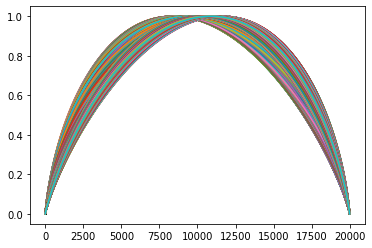

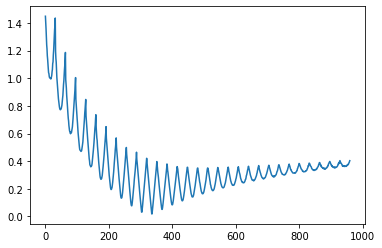

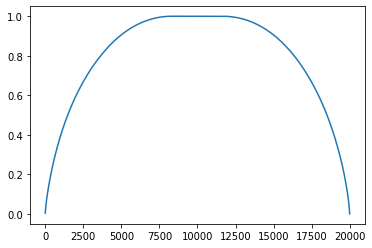

100%|████████████████████████████████████████| 960/960 [00:08<00:00, 111.57it/s]


In [40]:
ns = 20000
x0 = jnp.array([1.1, 0.3]) # WHATEVER 
d = 2
b_zero = jnp.array([1., 0.])

betas1 = jnp.linspace(0.4, 2.2, 30) ## set a bit larger range than you want to certify
betas2 = jnp.linspace(-0.5, 0.5, 32)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2)))) 


type_of_transform = 'cb'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi_bc = pxi_to_xi(p)
for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()

z = csaps([betas1, betas2], g.reshape(*betas1.shape, *betas2.shape)) # interpolate


hg = []

for beta in tqdm(betas):
    hat_g = g_to_hat_g(z, beta, b_zero)
    hg.append(hat_g)
    
hat_g = jnp.asarray(hg)

hatg_int_bc = csaps([betas1, betas2], hat_g.reshape(*betas1.shape, *betas2.shape)) #intterpolation of Integral g(beta)



In [57]:
xi = xi_bc
hatg_int = hatg_int_bc
xs = np.linspace(0.5, 1-1e-3, 200)
r_our = lambda h: -xi(1-h)+xi(0.5)
xi_tss = scipy.stats.norm.ppf
r_tss_bc= lambda h: 1/2*(xi_tss(h) - xi_tss(1-h))

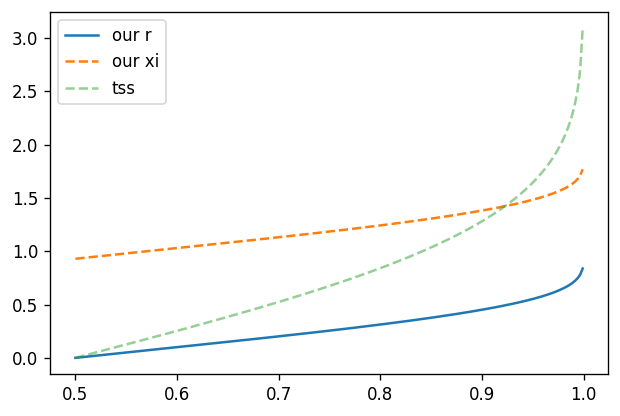

In [58]:
plt.figure(dpi=120)
plt.plot(xs, r_our(xs), label='our r')
plt.plot(xs, xi_bc(xs), '--', label='our xi')
plt.plot(xs, r_tss_bc(xs), '--', label='tss', alpha=0.5)
# plt.yscale('log')
plt.legend()
plt.show()


In [59]:
pwd

'/workspace/raid/data/dkorzh/general_lipschitz/notebooks'

In [60]:
!mkdir ../checkpoints/brightness

In [64]:
!cp /workspace/raid/data/dkorzh/TSS_FINAL_VERSION/semantic-randomized-smoothing/models/imagenet/resnet50/brightness/pretrain_noise_0.4_0.4/checkpoint.pth.tar ../checkpoints/brightness/checkpoint.pth.tar



In [79]:
checkpoint = torch.load('../checkpoints/brightness/checkpoint.pth.tar')
model = torchvision.models.resnet50(pretrained=False).to(device)#.cuda()
normalize_layer = get_normalize_layer('imagenet', device).to(device) #.cuda()
model = torch.nn.Sequential(normalize_layer, model)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

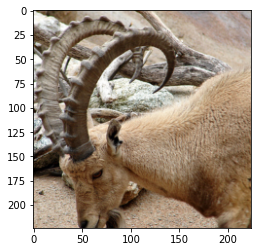

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


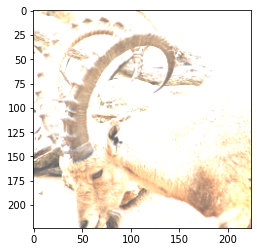

h normal based (pa) 0.9999357030272239
normal based pb 3.5416494287428914e-05
h from Clopper-Pearson (pa) 0.9982745514810885

Ground Truth Class (label) 350
Base classifier prediction in attacked image 350
TSS Smoothed classifier prediction in attacked image 350
Is smoothed classifier prediction in not-attacked image correct? 1
Is smoothed classifier prediction in ATTACKED image correct? 1

Safe beta our with h normal-based [[ True]]
Safe beta with h Clopper-Pearson [[ True]]


In [80]:
# image, label = next(iter(dataloader100))
k = 35
image = ourdataset100[k][0]
label = ourdataset100[k][1]
imshow(image)

base_classifier = model
x = image
label = label
Phi = phi_bc_torch_batch_and_noise
n0 = 200
maxn = 4000
alpha = 1e-3
batch_size = 128
adaptive=False

pa, pb, G_CORRECT_PREDICTION_VIA_I, G_CORRECT_PREDICTION_VIA_CI, pABar, cAHat = certify(base_classifier,  x, label, Phi, n0,  
                         maxn, alpha, batch_size, adaptive)

betas = np.array([1.5, .4])
image_attacked = attack_bc_torch(image, betas)
imshow(image_attacked)


base_classifier = model
x = image_attacked
label = label
Phi = phi_bc_torch_batch_and_noise
n0 = 100
maxn = 3000
alpha = 1e-3
batch_size = 128
adaptive=False

pa_a, pb_a, G_CORRECT_PREDICTION_VIA_I_a, G_CORRECT_PREDICTION_VIA_CI_a, pABar_a, cAHat_a = certify(base_classifier,  x, label, Phi, n0,  
                         maxn, alpha, batch_size, adaptive)


print('h normal based (pa)', pa.item())
print('normal based pb', pb.item())

print('h from Clopper-Pearson (pa)', pABar)
print()
print('Ground Truth Class (label)', label.item())
print('Base classifier prediction in attacked image', model(image_attacked.unsqueeze(0).to(device)).argmax().item())
print('TSS Smoothed classifier prediction in attacked image', cAHat_a)
print('Is smoothed classifier prediction in not-attacked image correct?', G_CORRECT_PREDICTION_VIA_CI)
print('Is smoothed classifier prediction in ATTACKED image correct?', G_CORRECT_PREDICTION_VIA_CI_a)
print()
print('Safe beta our with h normal-based', safe_beta(xi, pa, hatg_int, [*betas]))
print('Safe beta with h Clopper-Pearson', safe_beta(xi, pABar, hatg_int, [*betas]))


In [81]:
iscor_bc = Accuracy(model, loader=dataloader100, device=device) # Accuracy of non-smoothed model on original images

/tmp/ipykernel_46661/2576819265.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k, (images, labels) in enumerate(tqdm_notebook(loader)):


  0%|          | 0/100 [00:00<?, ?it/s]

0.67


In [82]:
betas0 = np.linspace(0.5, 2.0, 21) # Attack Radius
betas1 = np.linspace(-0.4, 0.4, 22)
betas = np.asarray(list(map(np.array, itertools.product(betas0, betas1))))

attack = attack_bc_torch

era = ERA_Only_ND(model, dataloader100, attack = attack, device=device, PSN = betas)

/tmp/ipykernel_46661/1667309012.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k, (images, labels) in enumerate(tqdm_notebook(loader)):


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_46661/1667309012.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attacked = torch.tensor(attacked)


tensor(0.5900)


In [83]:
2 + 2

4

In [ ]:
betas0 = np.linspace(0.5, 2.0, 2) # Attack Radius
betas1 = np.linspace(-0.4, 0.4, 2)
betas = np.asarray(list(map(np.array, itertools.product(betas0, betas1))))

attack = attack_bc_torch
Phi = phi_bc_torch_batch_and_noise
era_smoothed = ERA_Only_For_Smoothed_ND(model, dataloader100, attack, Phi, device, PSN=betas, n0=100, maxn=512, alpha=1e-3, batch_size=256, adaptive=False)
# tensor(0.6300)

In [85]:
Phi = phi_bc_torch_batch_and_noise
pas, isOk, paTSS, isOkTSS = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device, n0=100, maxn=2000, alpha=1e-3, batch_size=256, adaptive=False)

/tmp/ipykernel_46661/2576819265.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k, (image, label) in enumerate(tqdm_notebook(loader)):


  0%|          | 0/100 [00:00<?, ?it/s]

In [86]:
print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOk))

Ordinary accuracy of Smoothed Classiifer 0.67


In [87]:
betas0 = np.linspace(0.5, 2.0, 21) # Attack Radius
betas1 = np.linspace(-0.4, 0.4, 22)
betas = np.asarray(list(map(np.array, itertools.product(betas0, betas1))))

In [88]:
hlist = [0.2, 0.5, 0.53,0.55, 0.6, 0.62, 0.65, 0.66, 0.67, 0.68, 0.7, 0.8,0.83, 0.85, 0.87 ,0.9, 0.93]
hmin = CertAccChecker(betas=betas, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((pas>hmin).astype('int')*isOk).mean()
print('Cert Acc CB our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|███████████████████████████████████████| 462/462 [00:00<00:00, 3355.75it/s]

Cert Acc CB our 0.45 h_min is 0.85


In [89]:
hlist = [0.2, 0.5, 0.6, 0.63, 0.65, 0.66, 0.67, 0.68, 0.7, 0.8, 0.9, 0.995, 0.996, 0.99999999999999]
hmin = CertAccCheckerTSS(betas=betas, hlist=hlist, xi=xi_tss, safe_beta_tss=safe_beta_tss_bc)
cert_acc_within_betas_bounds = ((paTSS>hmin)*isOkTSS).mean()
print('Cert Acc CB TSS', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|███████████████████████████████████████| 462/462 [00:00<00:00, 1220.51it/s]

Cert Acc CB TSS 0.33 h_min is 0.995


In [90]:
def make_accuracy_df_cb(betas, hs, correct, safe_beta, ifTSS = False, ifOURnew=False, extent = None ):
    beta_d = {'c': list(), 'b':list()} #, 't2':list()
    accuracy = np.zeros(len(betas))

    for i, beta in enumerate(tqdm(betas)):
        beta_d['c'].append(beta[0])
        beta_d['b'].append(beta[1])

        if ifOURnew:
            for h1, isOk in zip(hs, correct):
                accuracy[i] += (safe_beta(xi, h1, hatg_int, (beta[0],beta[1])).item() * isOk) 
        elif ifTSS:
            for h1, isOk in zip(hs, correct):
#                 print(safe_beta(xi_tss, h1, (beta[0],beta[1])))
                accuracy[i] += (safe_beta(xi_tss, h1, (beta[0],beta[1])).item() * isOk) #, beta[2]

        accuracy[i] /= len(correct)
        #break
        
        
    cs = []
    bs = []
    accs = []
    all_params = []

    for i, (c, b) in enumerate(zip(beta_d['c'], beta_d['b'])):
        cs.append(c.item())
        b_ = b.item()
        bs.append(b_)
        accs.append(accuracy[i])

    css = []
    bss = []
    acc_d = {}
    for x,y,z in zip(cs, bs, accs):
        if not x in css:
            css.append(x)
        if not y in bss:
            bss.append(y)
        acc_d[x,y] = z
        
    accdf = pd.DataFrame(data = jnp.array(list(acc_d.values())).reshape(len(css), len(bss)), index=css, columns=bss)
    accdf = accdf.reindex(sorted(accdf.columns), axis=1)
    clps = []
    for x in accdf.values:
        z = (np.asarray(list(map(np.array, x))))
        clps.append(z)

    plt.figure(figsize=(12,7))
    plt.imshow(clps, extent=extent, aspect='auto')
    plt.title('Certified accuracy for composition of Contrast + Brightness', fontsize=15)
    plt.xlabel(r'Brightness parameter $b$', fontsize=15)
    plt.ylabel(r'$c$ contrast transform', fontsize=15)
    plt.colorbar();
    plt.show()

    return accdf, clps, acc_d

100%|█████████████████████████████████████████| 462/462 [00:14<00:00, 31.30it/s]


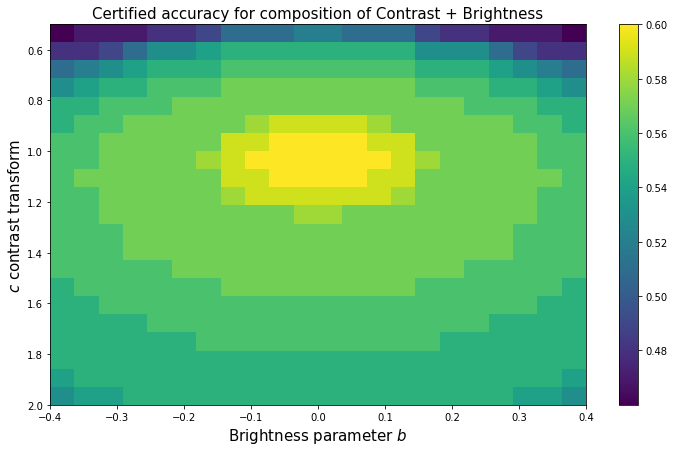

In [91]:
accdf, clps, acc_d = make_accuracy_df_cb(betas = betas, hs = pas, correct = isOk, safe_beta = safe_beta, ifTSS = False, ifOURnew=True, extent = [-0.4, 0.4, 2.0, 0.5] )




In [93]:
dirname

'results/'

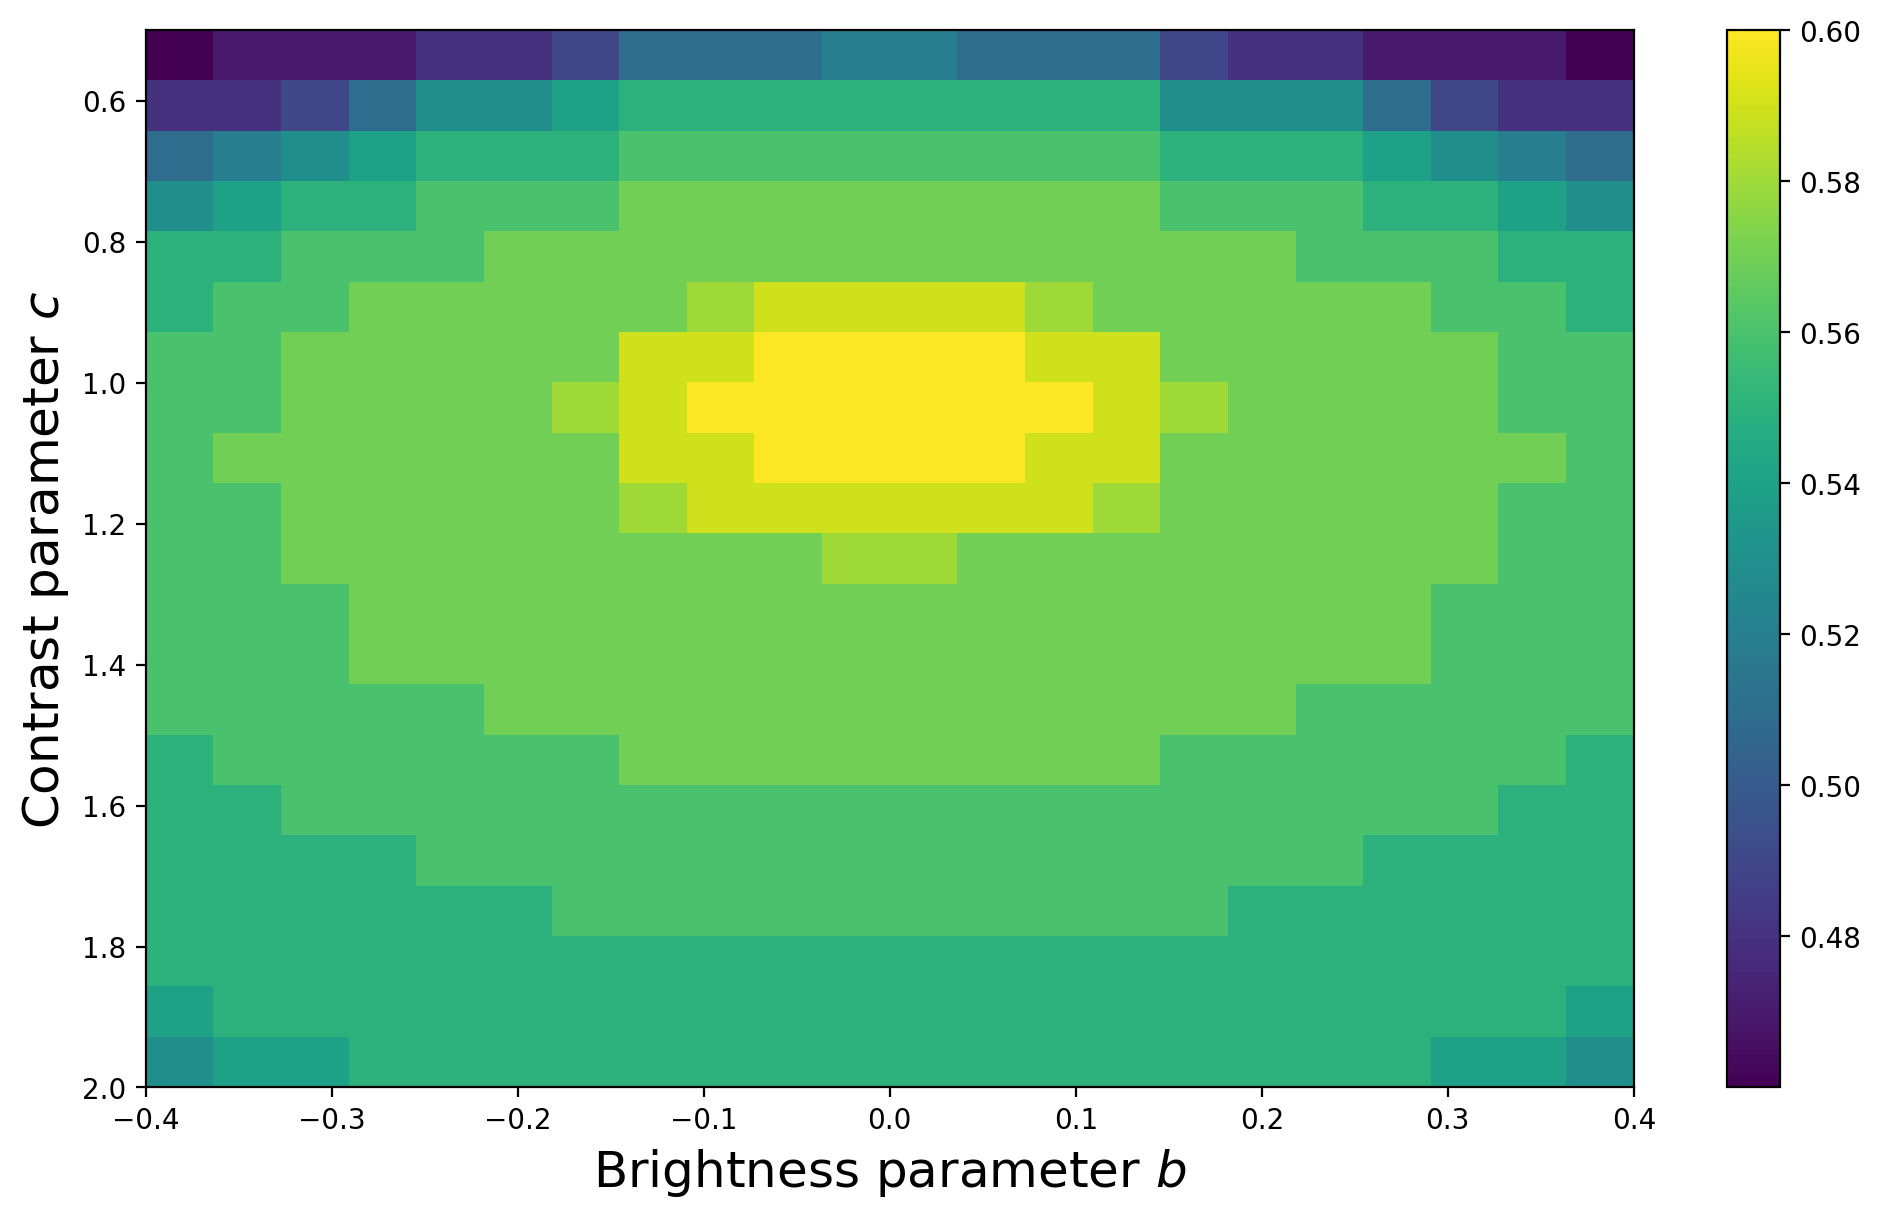

In [104]:
plt.figure(figsize=(12,7), dpi=200)
plt.imshow(clps, extent=[-0.4, 0.4, 2.0, 0.5] , aspect='auto')
#plt.set_ylabel([1., 11.])
# plt.title(r'Certified accuracy for composition of Contrast and Brightness. Our', fontsize=15)
plt.ylabel(r'Contrast parameter $c$', fontsize=18)
plt.xlabel(r'Brightness parameter $b$', fontsize=18)
plt.colorbar();
plt.savefig(dirname+'ContrastBrightness06.pdf')
plt.show()

In [94]:
min(list(acc_d.values()))

0.46

In [95]:
accdf.to_csv(dirname + 'Contrast+BrighttnessFinal.csv', index=False)


100%|█████████████████████████████████████████| 462/462 [00:38<00:00, 12.10it/s]


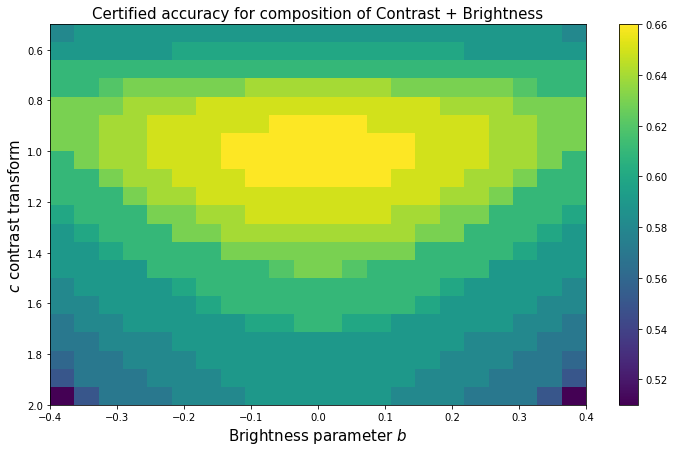

In [96]:
accdf_tss, clps_tss, acc_d = make_accuracy_df_cb(betas = betas, hs = paTSS, correct = isOkTSS, safe_beta = safe_beta_tss_bc, ifTSS = True, ifOURnew=False, extent = [-0.4, 0.4, 2.0, 0.5] )




In [97]:
min(list(acc_d.values()))

0.51

In [98]:
isOk

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1])

In [99]:
d = {}
# d['betas'] = list(betas)
# d['df'] = accdf_tss

# d['clps_tss'] = clps_tss
# d['acc_d'] = acc_d 
d['pas'] = list(pas)

d['isOk'] = list(map(int, list(isOk)))
d['paTSS'] = list(paTSS)
d['isOkTSS'] = list(map(int, list(isOkTSS)))

# pas, isOk, paTSS, isOkTSS

In [100]:
import json
with open(dirname+'BC_final.json', 'w') as f:
      json.dump(d, f, ensure_ascii=False)

In [102]:
pwd

'/workspace/raid/data/dkorzh/general_lipschitz/notebooks'

In [101]:
!ls $dirname

BC_final.json  Contrast+BrighttnessFinal.csv  ContrastBrightness06.pdf


# Gamma + Contrast

In [364]:
sigma_c = 0.1
sigma_gamma = 0.1

In [365]:
def attack_gc_torch(x, b):
    return (x**(torch.tensor(b[0].item()))) * torch.tensor(b[1].item())

# def norm_to_ray_torch(a,b):
#     return torch.sqrt(-torch.log((1-0.5*torch.erfc(-a/np.sqrt(2)))**2))


def phi_gc_torch_batch_and_noise(x, sigma_g=sigma_gamma, sigma_c = sigma_c):
    q = (torch.randn(len(x)) * sigma_g).to(device)
    q_= (torch.randn(len(x)) * sigma_g).to(device)
    q = torch.sqrt(q**2 + q_**2)
    
    q1 = (torch.randn(len(x)) * sigma_c).to(device)
    
    
    q = q[:, None, None, None]
    q1 = torch.exp(q1[:,None,None,None]) ## Norm to Lornorm
    return (x**q) * q1

In [366]:
ns = 10000
x0 = jnp.array([1.1,0.3]) # WHATEVER 
d = 2
b_zero = jnp.array([1.0, 1.0])

betas1 = jnp.linspace(0.4, 2.2, 30) ## set a bit larger range than you want to certify
betas2 = jnp.linspace(0.4, 2.2, 32)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2)))) 



type_of_transform = 'gc'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)


z = csaps([betas1, betas2], g.reshape(*betas1.shape, *betas2.shape)) # interpolate


hg = []

for beta in tqdm(betas):
    hat_g = g_to_hat_g(z, beta, b_zero)
    hg.append(hat_g)
    
hat_g = jnp.asarray(hg)

hatg_int = csaps([betas1, betas2], hat_g.reshape(*betas1.shape, *betas2.shape)) #intterpolation of Integral g(beta)



100%|█████████████████████████████████████████| 960/960 [00:10<00:00, 88.63it/s]


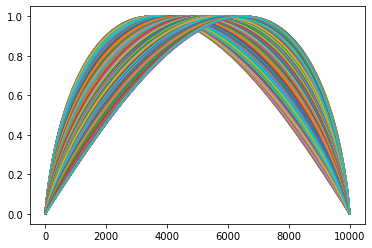

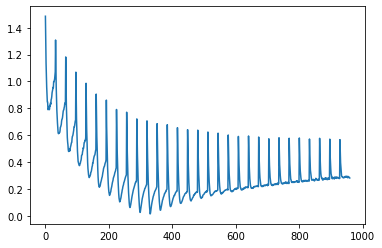

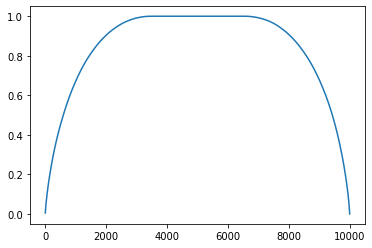

In [367]:
for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()

In [368]:
xs = np.linspace(0.5,1-1e-4,100)
r_our = lambda h: -xi(1-h)+xi(0.5)
# r_tss_bc= lambda h: 1/2*(xi(h) - xi(1-h))

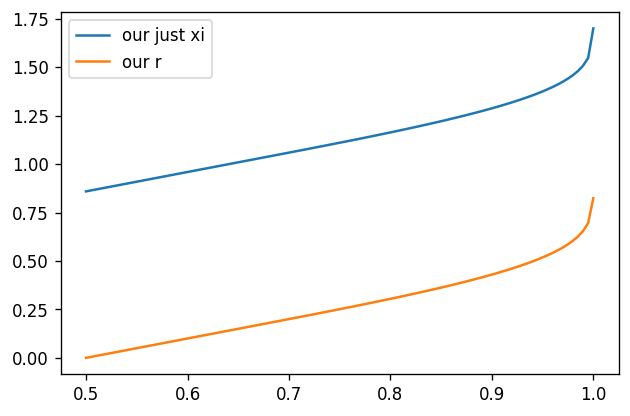

In [369]:
plt.figure(dpi=120)
plt.plot(xs, xi(xs), label='our just xi')
plt.plot(xs,r_our(xs), label='our r')
# plt.plot(xs, r_tss_bc(xs), '--', label='tss')
# plt.yscale('log')
plt.legend()
plt.show()


In [371]:
checkpoint = torch.load('./../checkpoints/_GCGCGC_checkpoint.pth.tar')
model = torchvision.models.resnet50(pretrained=False).to(device)#.cuda()
normalize_layer = get_normalize_layer('imagenet', device).to(device)#.cuda()
model = torch.nn.Sequential(normalize_layer, model)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

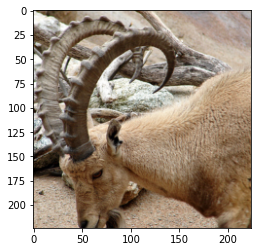

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


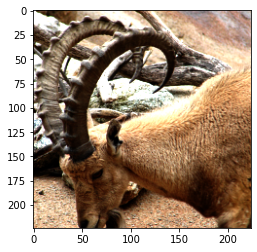

h normal based (pa) 0.9998133828962951
normal based pb 0.00012162097484313508
h from Clopper-Pearson (pa) 0.9965520801347684

Ground Truth Class (label) 350
Base classifier prediction in attacked image 350
TSS Smoothed classifier prediction in attacked image 350
Is smoothed classifier prediction in not-attacked image correct? 1
Is smoothed classifier prediction in ATTACKED image correct? 1

Safe beta our with h normal-based [[ True]]
Safe beta with h Clopper-Pearson [[ True]]


In [372]:
# image, label = next(iter(dataloader100))
k = 35
image = ourdataset100[k][0]
label = ourdataset100[k][1]
imshow(image)

base_classifier = model
x = image
label = label
Phi = phi_gc_torch_batch_and_noise
n0 = 200
maxn = 2000
alpha = 1e-3
batch_size = 128
adaptive=False

pa, pb, G_CORRECT_PREDICTION_VIA_I, G_CORRECT_PREDICTION_VIA_CI, pABar, cAHat = certify(base_classifier,  x, label, Phi, n0,  
                         maxn, alpha, batch_size, adaptive)



betas = np.array([1.9, 1.5])
image_attacked = attack_gc_torch(image, betas)
imshow(image_attacked)


base_classifier = model
x = image_attacked
label = label
Phi = phi_bc_torch_batch_and_noise
n0 = 100
maxn = 3000
alpha = 1e-3
batch_size = 128
adaptive=False

pa_a, pb_a, G_CORRECT_PREDICTION_VIA_I_a, G_CORRECT_PREDICTION_VIA_CI_a, pABar_a, cAHat_a = certify(base_classifier,  x, label, Phi, n0,  
                         maxn, alpha, batch_size, adaptive)


print('h normal based (pa)', pa.item())
print('normal based pb', pb.item())

print('h from Clopper-Pearson (pa)', pABar)
print()
print('Ground Truth Class (label)', label.item())
print('Base classifier prediction in attacked image', model(image_attacked.unsqueeze(0).to(device)).argmax().item())
print('TSS Smoothed classifier prediction in attacked image', cAHat_a)
print('Is smoothed classifier prediction in not-attacked image correct?', G_CORRECT_PREDICTION_VIA_CI)
print('Is smoothed classifier prediction in ATTACKED image correct?', G_CORRECT_PREDICTION_VIA_CI_a)
print()
print('Safe beta our with h normal-based', safe_beta(xi, pa, hatg_int, [*betas]))
print('Safe beta with h Clopper-Pearson', safe_beta(xi, pABar, hatg_int, [*betas]))


In [373]:
iscor = Accuracy(model, loader=dataloader100, device=device) # Accuracy of non-smoothed model on original images

100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 19.22it/s]

0.72


In [374]:
betas0 = np.linspace(0.5, 2.0, 11) # Attack Raxdius
betas1 = np.linspace(0.5, 2.0, 12)

betas = np.asarray(list(map(np.array, itertools.product(betas0, betas1))))
era = ERA_Only_ND(model, dataloader100, attack = attack_gc_torch, device=device, PSN = betas)

#0.52

  0%|                                                   | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_46661/1961495464.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attacked = torch.tensor(attacked)
100%|█████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]

tensor(0.6800)


In [375]:
print(era)

tensor(0.6800)


In [376]:
betas0 = np.linspace(0.5, 2.0, 2) # Attack Radius
betas1 = np.linspace(0.5, 2.0, 2)
betas = np.asarray(list(map(np.array, itertools.product(betas0, betas1))))

attack = attack_gc_torch
Phi = phi_gc_torch_batch_and_noise
era_smoothed = ERA_Only_For_Smoothed_ND(model, dataloader100, attack, Phi, device, PSN=betas, n0=100, maxn=512, alpha=1e-3, batch_size=256, adaptive=False)

  0%|                                                   | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_46661/1679840911.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attacked = torch.tensor(attacked)
  1%|▍                                          | 1/100 [00:02<04:07,  2.50s/it]/tmp/ipykernel_46661/1679840911.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attacked = torch.tensor(attacked)
/tmp/ipykernel_46661/1679840911.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attacked = torch.tensor(attacked)
/tmp/ipykernel_46661/167984

tensor(0.6100)


In [377]:
print(era_smoothed)

tensor(0.6100)


In [378]:
Phi = phi_gc_torch_batch_and_noise
pas, isOk, paTSS, isOkTSS = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device, n0=100, maxn=1000, alpha=1e-3, batch_size=256, adaptive=False)

100%|█████████████████████████████████████████| 100/100 [01:48<00:00,  1.09s/it]


In [379]:
print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOk))

Ordinary accuracy of Smoothed Classiifer 0.71


100%|█████████████████████████████████████████| 462/462 [00:14<00:00, 31.61it/s]


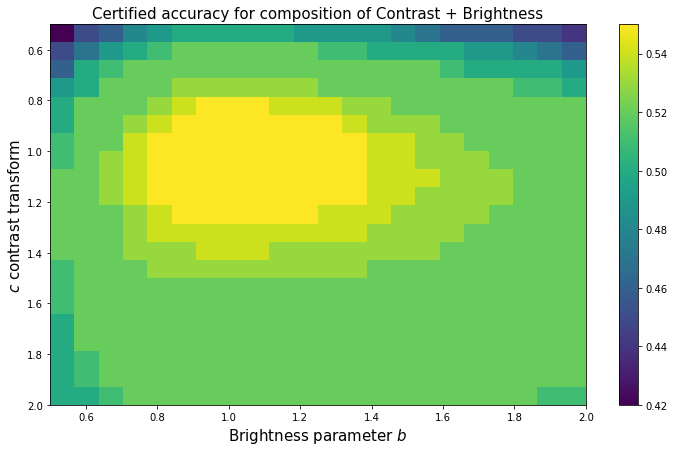

In [391]:
r11 = 0.5
r12 = 2.0
r21 = 0.5
r22 = 2.0
betas0 = np.linspace(r11, r12, 21) # Attack Raxdius
betas1 = np.linspace(r21, r22, 22)

betas = np.asarray(list(map(np.array, itertools.product(betas0, betas1))))
accdf, clps, acc_d = make_accuracy_df_cb(betas = betas, hs = pas, correct = isOk, safe_beta = safe_beta, ifTSS = False, ifOURnew=True, extent = [r21, r22, r12,r11])




In [392]:
accdf.shape

(21, 22)

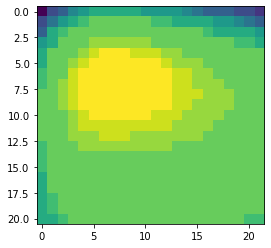

In [393]:
plt.imshow(accdf)

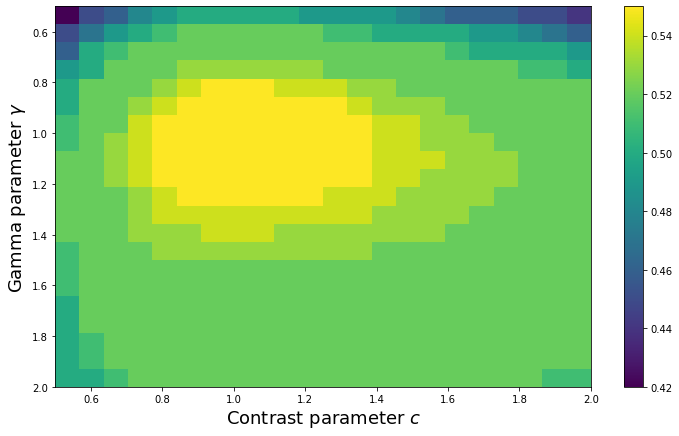

In [394]:
plt.figure(figsize=(12,7))
plt.imshow(clps, extent = [r21, r22, r12,r11] , aspect='auto')
#plt.set_ylabel([1., 11.])
# plt.title('Certified accuracy for composition of Gamma+Contrast. Our', fontsize=15)
plt.xlabel(r'Contrast parameter $c$', fontsize=18)
plt.ylabel(r'Gamma parameter $\gamma$', fontsize=18)
plt.colorbar();
plt.savefig('./../results/GammaContrast1109.pdf')
plt.show()

In [395]:
hlist = [0.5, 0.55, 0.555, 0.56, 0.57, 0.58, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65,0.68, 0.7, 0.72, 0.73,0.78,0.783, 0.79, 0.799, 0.8, 0.91, 0.92, 0.93,0.95, 0.96,0.965, 0.97, 0.98, 0.99, 1]
# hlist = np.linspace(0.8, 1, 300)
hmin = CertAccChecker(betas=betas, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((pas>hmin).astype('int')*isOk).mean()
print('Cert Acc TBBC our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|███████████████████████████████████████| 462/462 [00:00<00:00, 3041.22it/s]

Cert Acc TBBC our 0.33 h_min is 0.91


In [396]:
min(list(acc_d.values()))

0.42

In [386]:
d = {}
# d['betas'] = list(betas)
# d['df'] = accdf_tss

# d['clps_tss'] = clps_tss
# d['acc_d'] = acc_d 
d['pas'] = list(pas)

d['isOk'] = list(map(int, list(isOk)))
d['paTSS'] = list(paTSS)
d['isOkTSS'] = list(map(int, list(isOkTSS)))

# pas, isOk, paTSS, isOkTSS

In [387]:
import json
with open('./../results/GC_final.json', 'w') as f:
      json.dump(d, f, ensure_ascii=False)

# Brightness + Translation

In [ ]:
sigma_b = 0.8
sigma_tr = 30

In [ ]:
def phi_bt_torch_batch_and_noise(x):
    
    sigma = sigma_b
    tau = sigma_tr
#     x = x.expand(nsamples, *x.shape)
    x = x.to(device)
    
    q = torch.randn(len(x)) * sigma
    q = q[:,None,None,None]
    x = x + q.to(device)
    
    c1 = (torch.randn(len(x)) * tau).long()*1.0
    c2 = (torch.randn(len(x)) * tau).long()*1.0
    
    c1 = c1[:, None, None, None]
    c2 = c2[:, None, None, None]

    t = torch.tensor([1,0])
    T = t.expand(len(x), *t.shape).clone()
    T[:, 0] = c1.squeeze().clone()
    T[:, 1] = c2.squeeze().clone()
    out = kornia.geometry.transform.translate(x, T.float().to(device), padding_mode='reflection')
    return out

def attack_bt_torch(x, b):
    x = x.to(device) + torch.tensor(b[0].item())
    
    translation = torch.tensor([[b[1].item(), b[2].item()]]).to(device) #torch.tensor()

    out = kornia.geometry.transform.translate(x, translation, padding_mode='reflection')
#     print('Shape after attack', out.shape)
    return out

In [ ]:
#Brightness + Translation
ns = 100000
x0 = jnp.array([1.0,3.0, 3.]) #additive
d = 3
b_zero = jnp.array([0., 0., 0.])
betas1 = jnp.linspace(-0.3, 0.3, 13)

betas2 = jnp.linspace(-60.0, 60.0, 19).astype(int) * 1.0
betas3 = jnp.linspace(-60.0, 60.0, 19).astype(int) * 1.0
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3)))) 

type_of_transform = 'bt'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)

z = csaps([betas1, betas2 ,betas3], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape))


hg = []

for beta in tqdm(betas):
    hat_g = g_to_hat_g(z, beta, b_zero)
    hg.append(hat_g)
    
    
hat_g = jnp.asarray(hg)

hatg_int = csaps([betas1, betas2, betas3], hat_g.reshape(*betas1.shape, *betas2.shape, *betas3.shape)) 

In [ ]:
xs = np.linspace(0.5,1-1e-4,100)
r_our = lambda h: -xi(1-h)+xi(0.5)
# r_tss_bc= lambda h: 1/2*(xi(h) - xi(1-h))

plt.figure(dpi=120)
plt.plot(xs, xi(xs), label='our just xi')
plt.plot(xs,r_our(xs), label='our r')
# plt.plot(xs, r_tss_bc(xs), '--', label='tss')
# plt.yscale('log')
plt.legend()
plt.show()


In [ ]:

# checkpoint = torch.load('ReportResults/gcNEWContrastBrightTrans_08_08_50_checkpoint.pth.tar')

In [ ]:

checkpoint = torch.load('ReportResults/ContrasttTrans_08_40_checkpoint.pth.tar')

In [ ]:
checkpoint = torch.load('ReportResults/BrightTrans_08_408_checkpoint.pth.tar')
model = torchvision.models.resnet50(pretrained=False).to(device)#.cuda()
normalize_layer = get_normalize_layer('imagenet').to(device)#.cuda()
model = torch.nn.Sequential(normalize_layer, model)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [ ]:
iscor = Accuracy(model, loader=dataloader100, device=device) # Accuracy of non-smoothed model on original images

In [ ]:
betas0 = np.linspace(-0.2, .2, 3) # Attack Raxdius
betas1 = np.linspace(-56, 56, 3)
betas2 = np.linspace(-56, 56, 3)
attack = attack_bt_torch
betas = np.asarray(list(map(np.array, itertools.product(betas0, betas1, betas2))))
era = ERA_Only_ND(model, dataloader100, attack =attack , device=device, PSN = betas)

In [ ]:
print(era)

In [ ]:
betas0 = np.linspace(-0.2, .2, 2) # Attack Raxdius
betas1 = np.linspace(-56, 56, 2)
betas2 = np.linspace(-56, 56, 2)
attack = attack_bt_torch
betas = np.asarray(list(map(np.array, itertools.product(betas0, betas1, betas2))))



attack = attack_bt_torch
Phi = phi_bt_torch_batch_and_noise
era_smoothed = ERA_Only_For_Smoothed_ND(model, dataloader100, attack, Phi, device, PSN=betas, n0=100, maxn=512, alpha=1e-3, batch_size=256, adaptive=False)

In [ ]:
print(era_smoothed)

In [ ]:
betas1 = jnp.linspace(-0.3, 0.3, 13)

betas2 = jnp.linspace(-60.0, 60.0, 19).astype(int) * 1.0
betas3 = jnp.linspace(-60.0, 60.0, 19).astype(int) * 1.0
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3)))) 

In [ ]:
def make_accuracy_df_3D_to_2D_trans(betas, hs, correct, safe_beta = safe_beta,
                                    ifTSS = False, ifOURnew=False, extent = [0, 80.0, -0.2, 0.2], name = 'Certified accuracy for composition of Brightness+Translation'):
    beta_d = {'b': list(), 't1':list(), 't2':list()}
    accuracy = np.zeros(len(betas))

    for i, beta in enumerate(tqdm(betas)):
        beta_d['b'].append(beta[0])
        beta_d['t1'].append(beta[1])
        beta_d['t2'].append(beta[2])
        
        if ifOURnew:
            for h1, isOk in zip(hs, correct):
                accuracy[i] += (safe_beta(xi, h1, hatg_int, (beta[0],beta[1], beta[1])).item() * isOk) #, beta[2]
        elif ifTSS:
            for h1, isOk in zip(hs, correct):
                accuracy[i] += (safe_beta(xi_tss, h1, [*beta]).item() * isOk) #, beta[2]

        accuracy[i] /= len(correct)

    
    tn = []
    bs = []
    accs = []
    all_params = []

    for i, (b, t1, t2) in enumerate(zip(beta_d['b'], beta_d['t1'], beta_d['t2'])):
        t_norm = jnp.linalg.norm([t1, t2]).item()
        b_ = b.item()
        tn.append(t_norm)
        bs.append(b_)
        accs.append(accuracy[i])


    tns = []
    bss = []
    acc_d = {}
    for x,y,z in zip(tn, bs, accs):
        if not x in tns:
            tns.append(x)
        if not y in bss:
            bss.append(y)
        acc_d[x,y] = z
        
    accdf = pd.DataFrame(data = jnp.array(list(acc_d.values())).reshape(len(bss), len(tns)), index=bss, columns=tns)
    accdf = accdf.reindex(sorted(accdf.columns), axis=1)
    clps = []
    for x in accdf.values:
        z = (np.asarray(list(map(np.array, x))))
        clps.append(z)

    plt.figure(figsize=(12,7))
    plt.imshow(clps, extent=extent, aspect='auto')
    #plt.set_ylabel([1., 11.])
    plt.title(name, fontsize=15)
    plt.xlabel(r'||v|| of translation parameter v', fontsize=15)
    plt.ylabel(r'$b$ brightness transform', fontsize=15)
    plt.colorbar();
    if ifOURnew:
        plt.savefig(dirname+'bt_our.png')
    else:
        plt.savefig(dirname+'bt_tss.png')
    return accdf, clps, acc_d

In [ ]:
Phi = phi_bt_torch_batch_and_noise
pas, isOk, paTSS, isOkTSS = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device, n0=100, maxn=1000, alpha=1e-3, batch_size=128, adaptive=False)

In [ ]:
hlist = [0.8, 0.913, 0.92, 0.925, 0.95, 0.96,0.965, 0.97, 0.98, 0.99]
hmin = CertAccChecker(betas=betas, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((pas>hmin).astype('int')*isOk).mean()
print('Cert Acc BT our', cert_acc_within_betas_bounds, 'h_min is', hmin)

In [ ]:
isOk.mean()

In [ ]:
def safe_beta_tss_bt(xi, h, beta, sigma=sigma_b, tau=sigma_tr):
    
    l1 = (beta[0]/sigma)**2
    l2 = (beta[1]/tau)**2
    l3 = (beta[2]/tau)**2
    l = np.sqrt(l1+l2+l3)
    r = 1/2*(xi(h) - xi(1-h))
    
    return l<=r

In [ ]:
hlist = [0.5, 0.6, 0.63, 0.65, 0.66, 0.67, 0.68, 0.7, 0.8, 0.9, 0.92, 0.995, 0.99555,0.9965, 0.997, 0.999, 0.99999999999999]
hmin = CertAccCheckerTSS(betas=betas, hlist=hlist, xi=xi_tss, safe_beta_tss=safe_beta_tss_bt)
cert_acc_within_betas_bounds = ((paTSS>hmin)*isOkTSS).mean()
print('Cert Acc CB TSS', cert_acc_within_betas_bounds, 'h_min is', hmin)

In [ ]:
isOk.mean()

In [ ]:
accdf, clps, acc_d = make_accuracy_df_3D_to_2D_trans(betas = betas, hs = pas, correct = isOk, safe_beta = safe_beta, ifTSS = False, ifOURnew=True)

In [ ]:
min(list(acc_d.values()))

In [ ]:
accdf_tss, clps_tss, acc_d_tss = make_accuracy_df_3D_to_2D_trans(betas = betas, hs = paTSS, correct = isOkTSS, safe_beta = safe_beta_tss_bt, ifTSS = True, ifOURnew=False)

In [ ]:
min(list(acc_d_tss.values()))

In [ ]:
d = {}
# d['betas'] = list(betas)
# d['df'] = accdf_tss

# d['clps_tss'] = clps_tss
# d['acc_d'] = acc_d 
d['pas'] = list(pas)

d['isOk'] = list(map(int, list(isOk)))
d['paTSS'] = list(paTSS)
d['isOkTSS'] = list(map(int, list(isOkTSS)))

# pas, isOk, paTSS, isOkTSS

import json
with open(dirname+'BT_final.json', 'w') as f:
      json.dump(d, f, ensure_ascii=False)

# Contrast + Translation

In [ ]:
sigma_c = 0.8
sigma_tr =30


In [ ]:
def attack_ct_torch(x, b): #trans bright blur contrast
#     print(b)
    x = x.to(device)
    x = torch.tensor(b[0].item())*x
    translation = torch.tensor([[b[1].item(), b[2].item()]]).to(torch.float).to(device) #torch.tensor()
    out = kornia.geometry.transform.translate(x, translation, padding_mode='reflection')
    return out

def phi_ct_torch_batch_and_noise(x): #trans bright blur contrast
    
    
    x = x.to(device)
    contr = (torch.randn(len(x)) * sigma_c)[:, None, None, None].to(device)
    x = contr * x
    c1 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    c2 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    
    t = torch.tensor([1,0])
    T = t.expand(len(x), *t.shape).clone()
    T[:, 0] = c1.squeeze().clone()
    T[:, 1] = c2.squeeze().clone()
    
    out = kornia.geometry.transform.translate(x.to(device), T.float().to(device), padding_mode='reflection')
    return out

In [ ]:
ns = 100000
x0 = jnp.array([1.1,0.3]) # WHATEVER 
d = 3
b_zero = jnp.array([1.0, 0.0, 0.0])

betas1 = jnp.linspace(0.4, 2.2, 12) ## set a bit larger range than you want to certify
betas2 = jnp.linspace(-60, 60, 17)
betas3 = jnp.linspace(-60, 60, 17)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3)))) 

type_of_transform = 'ct'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)

z = csaps([betas1, betas2 ,betas3], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape))


hg = []

for beta in tqdm(betas):
    hat_g = g_to_hat_g(z, beta, b_zero)
    hg.append(hat_g)
    
    
hat_g = jnp.asarray(hg)

hatg_int = csaps([betas1, betas2, betas3], hat_g.reshape(*betas1.shape, *betas2.shape, *betas3.shape)) 

In [ ]:
xs = np.linspace(0.5,1-1e-4,100)
r_our = lambda h: -xi(1-h)+xi(0.5)
# r_tss_bc= lambda h: 1/2*(xi(h) - xi(1-h))

In [ ]:
plt.figure(dpi=120)
plt.plot(xs, xi(xs), label='our just xi')
plt.plot(xs, r_our(xs), label='our r')
# plt.plot(xs, r_tss_bc(xs), '--', label='tss')
# plt.yscale('log')
plt.legend()
plt.show()


In [ ]:
checkpoint = torch.load('ReportResults/ContrasttTrans_08_40_checkpoint.pth.tar')
model = torchvision.models.resnet50(pretrained=False).to(device)#.cuda()
normalize_layer = get_normalize_layer('imagenet').to(device)#.cuda()
model = torch.nn.Sequential(normalize_layer, model)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [ ]:
iscor = Accuracy(model, loader=dataloader100, device=device) # Accuracy of non-smoothed model on original images

In [ ]:
# betas0 = np.linspace(0.5, 2, 3) # Attack Raxdius
# betas1 = np.linspace(-56, 56, 3)
# betas2 = np.linspace(-56, 56, 3)

betas1 = jnp.linspace(0.8, 1.2, 10) ## set a bit larger range than you want to certify
betas2 = jnp.linspace(-25, 25, 11)
betas3 = jnp.linspace(-25, 25, 11)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3))))


attack = attack_ct_torch

era = ERA_Only_ND(model, dataloader100, attack =attack , device=device, PSN = betas)

In [ ]:
print(era)

In [ ]:
# betas0 = np.linspace(0.5, 2.0, 2) # Attack Raxdius
# betas1 = np.linspace(-56, 56, 2)
# betas2 = np.linspace(-56, 56, 2)
# betas = np.asarray(list(map(np.array, itertools.product(betas0, betas1, betas2))))

betas1 = jnp.linspace(0.8, 1.2, 10) ## set a bit larger range than you want to certify
betas2 = jnp.linspace(-25, 25, 11)
betas3 = jnp.linspace(-25, 25, 11)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3))))



attack = attack_ct_torch
Phi = phi_ct_torch_batch_and_noise
era_smoothed = ERA_Only_For_Smoothed_ND(model, dataloader100, attack, Phi, device, PSN=betas, n0=100, maxn=512, alpha=1e-3, batch_size=256, adaptive=False)

In [ ]:
print(era_smoothed)

In [ ]:
Phi = phi_ct_torch_batch_and_noise
pas, isOk, paTSS, isOkTSS = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device, n0=100, maxn=1000, alpha=1e-3, batch_size=128, adaptive=False)

In [ ]:
hlist = [0.8, 0.913, 0.92, 0.925, 0.95, 0.96,0.965, 0.97, 0.98, 0.99]
hmin = CertAccChecker(betas=betas, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((pas>hmin).astype('int')*isOk).mean()
print('Cert Acc CT our', cert_acc_within_betas_bounds, 'h_min is', hmin)

In [ ]:
isOk.mean()

In [ ]:
betas1 = jnp.linspace(0.8, 1.2, 10) ## set a bit larger range than you want to certify
betas2 = jnp.linspace(-25, 25, 11)
betas3 = jnp.linspace(-25, 25, 11)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3))))


accdf, clps, acc_d = make_accuracy_df_3D_to_2D_trans(betas = betas, hs = pas, correct = isOk, safe_beta = safe_beta, ifTSS = False, ifOURnew=True)

In [ ]:
hlist = [0.7,0.735, 0.74, 0.75, 0.8, 0.913, 0.92, 0.925, 0.95, 0.96,0.965, 0.97, 0.98, 0.99]
hmin = CertAccChecker(betas=betas, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((pas>hmin).astype('int')*isOk).mean()
print('Cert Acc CT our', cert_acc_within_betas_bounds, 'h_min is', hmin)

In [ ]:
min(list(acc_d.values()))

In [ ]:
checkpoint = torch.load('ReportResults/TBBC_40_08_sqrt(30)_08_checkpoint.pth.tar')
model = torchvision.models.resnet50(pretrained=False).to(device)#.cuda()
normalize_layer = get_normalize_layer('imagenet').to(device)#.cuda()
model = torch.nn.Sequential(normalize_layer, model)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [ ]:
def attack_ct_torch(x, b): #trans bright blur contrast
#     print(b)
    x = x.to(device)
    x = torch.tensor(b[0].item())*x
    translation = torch.tensor([[b[1].item(), b[2].item()]]).to(torch.float).to(device) #torch.tensor()
    out = kornia.geometry.transform.translate(x, translation, padding_mode='reflection')
    return out

def phi_ct_torch_batch_and_noise(x, sigma_tr =sigma_tr, sigma_c = sigma_c): #trans bright blur contrast
    
    
    x = x.to(device)
    contr = torch.exp(torch.randn(len(x)) * sigma_c)[:, None, None, None].to(device)
    x = contr * x
    c1 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    c2 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    
    t = torch.tensor([1,0])
    T = t.expand(len(x), *t.shape).clone()
    T[:, 0] = c1.squeeze().clone()
    T[:, 1] = c2.squeeze().clone()
    
    out = kornia.geometry.transform.translate(x.to(device), T.float().to(device), padding_mode='reflection')
    return out

In [ ]:
ns = 10000
x0 = jnp.array([0.0,0.0, 3.])
d = 3
b_zero = jnp.array([1.0, 0.0, 0.0])

betas1 = jnp.linspace(0.4, 2.1, 16)
betas2 = jnp.linspace(-60.0, 60.0, 12).astype(int) * 1.0 # set more steps
betas3 = jnp.linspace(-60.0, 60.0, 12).astype(int) * 1.0

betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3)))) 

type_of_transform = 'ct'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)
# z = csaps([betas1, betas2 ,betas3, betas4, betas5], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape, *betas4.shape, *betas5.shape))

z = csaps([betas1, betas2, betas3], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape))


# z = csaps([betas1, betas2 ,betas3], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape))

hg = []

for beta in tqdm(betas):
    hat_g = g_to_hat_g(z, beta, b_zero)
    hg.append(hat_g)
    
    
hat_g = jnp.asarray(hg)

hatg_int = csaps([betas1, betas2, betas3], hat_g.reshape(*betas1.shape, *betas2.shape, *betas3.shape)) 



In [ ]:
betas1 = jnp.linspace(0.5, 2.0, 12)
betas2 = jnp.linspace(-56.0, 56.0, 8).astype(int) * 1.0 # set more steps
betas3 = jnp.linspace(-56.0, 56.0, 8).astype(int) * 1.0
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3)))) 

In [ ]:
betas_0 = np.array([1.5, 30, 40])
image_attacked = attack_ct_torch(image, betas_0)
imshow(image_attacked)

In [ ]:
attack = attack_ct_torch

era = ERA_Only_ND(model, dataloader100, attack =attack , device=device, PSN = betas)

In [ ]:
Phi = phi_tr_torch_batch_and_noise
pas, isOk, paTSS, isOkTSS = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device, n0=100, maxn=3000, alpha=1e-3, batch_size=256, adaptive=False)





In [ ]:
isOk.mean()

In [ ]:
def make_accuracy_df_3D_to_2D_trans(betas, hs, correct, hatg_int, safe_beta = safe_beta,
                                    ifTSS = False, ifOURnew=False, extent = [0, 80.0, 0.5, 2.0], name = 'Certified accuracy for composition of Contrast and Translation'):
    beta_d = {'c': list(), 't1':list(), 't2':list()}
    accuracy = np.zeros(len(betas))

    for i, beta in enumerate(tqdm(betas)):
        beta_d['c'].append(beta[0])
        beta_d['t1'].append(beta[1])
        beta_d['t2'].append(beta[2])
        
        if ifOURnew:
            for h1, isOk in zip(hs, correct):
                accuracy[i] += (safe_beta(xi, h1, hatg_int, (beta[0],beta[1], beta[1])).item() * isOk) #, beta[2]
        elif ifTSS:
            for h1, isOk in zip(hs, correct):
                accuracy[i] += (safe_beta(xi_tss, h1, [*beta]).item() * isOk) #, beta[2]

        accuracy[i] /= len(correct)

    
    tn = []
    cs = []
    accs = []
    all_params = []

    for i, (c, t1, t2) in enumerate(zip(beta_d['c'], beta_d['t1'], beta_d['t2'])):
        t_norm = jnp.linalg.norm([t1, t2]).item()
        c_ = c.item()
        tn.append(t_norm)
        cs.append(c_)
        accs.append(accuracy[i])


    tns = []
    css = []
    acc_d = {}
    for x,y,z in zip(tn, cs, accs):
        if not x in tns:
            tns.append(x)
        if not y in css:
            css.append(y)
        acc_d[x,y] = z
        
    accdf = pd.DataFrame(data = jnp.array(list(acc_d.values())).reshape(len(css), len(tns)), index=css, columns=tns)
    accdf = accdf.reindex(sorted(accdf.columns), axis=1)
    clps = []
    for x in accdf.values:
        z = (np.asarray(list(map(np.array, x))))
        clps.append(z)

    plt.figure(figsize=(12,7))
    plt.imshow(clps, extent=extent, aspect='auto')
    #plt.set_ylabel([1., 11.])
    plt.title(name, fontsize=15)
    plt.xlabel(r'||v|| of translation parameter v', fontsize=15)
    plt.ylabel(r'$b$ contrast transform', fontsize=15)
    plt.colorbar();
    if ifOURnew:
        plt.savefig(dirname+'ct_our.png')
    else:
        plt.savefig(dirname+'ct_tss.png')
    return accdf, clps, acc_d

In [ ]:
accdf, clps, acc_d = make_accuracy_df_3D_to_2D_trans(betas, pas, isOk, hatg_int, safe_beta = safe_beta, ifTSS = False, ifOURnew=True, extent = [0, 80.0, 0.5, 2.0])





In [ ]:
min(list(acc_d.values()))

# Contrast + Brightnest + Translation. V2. Smaller Params

In [ ]:
sigma_tr = 30
sigma_c = 0.4
sigma_b = 0.4


In [ ]:
checkpoint = torch.load('ReportResults/TBBC_40_08_sqrt(30)_08_checkpoint.pth.tar')
model = torchvision.models.resnet50(pretrained=False).to(device)#.cuda()
normalize_layer = get_normalize_layer('imagenet').to(device)#.cuda()
model = torch.nn.Sequential(normalize_layer, model)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [ ]:
def attack_cbt_torch(x, b): #trans bright blur contrast
#     print(b)
    x = x.to(device)
    x = torch.tensor(b[0].item())*x
    x = x + torch.tensor(b[1].item())
    translation = torch.tensor([[b[2].item(), b[3].item()]]).to(torch.float).to(device) #torch.tensor()
    out = kornia.geometry.transform.translate(x, translation, padding_mode='reflection')
    return out

def phi_cbt_torch_batch_and_noise(x): #trans bright blur contrast
    
    
    x = x.to(device)
    
    contr = (torch.randn(len(x)) * sigma_c)[:, None, None, None].to(device)
    x = contr * x
    b = (torch.randn(len(x)) * sigma_b)[:, None, None, None].to(device)
    x = x + b
    c1 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    c2 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    
    t = torch.tensor([1,0])
    T = t.expand(len(x), *t.shape).clone()
    T[:, 0] = c1.squeeze().clone()
    T[:, 1] = c2.squeeze().clone()
    
    out = kornia.geometry.transform.translate(x.to(device), T.float().to(device), padding_mode='reflection')
    return out

In [ ]:
ns = 10000
x0 = jnp.array([0.0,0.0, 3.])
d = 4
b_zero = jnp.array([1.0, 0.0, 0.0, 0.0])

betas1 = jnp.linspace(0.7, 1.6, 9)
betas2 = jnp.linspace(-0.3, 0.3, 9)
betas3 = jnp.linspace(-30.0, 30.0, 9).astype(int) * 1.0 # set more steps
betas4 = jnp.linspace(-30.0, 30.0, 9).astype(int) * 1.0

betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3, betas4)))) 

type_of_transform = 'cbt'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)
# z = csaps([betas1, betas2 ,betas3, betas4, betas5], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape, *betas4.shape, *betas5.shape))

z = csaps([betas1, betas2, betas3, betas4], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape, *betas4.shape))


# z = csaps([betas1, betas2 ,betas3], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape))

hg = []

for beta in tqdm(betas):
    hat_g = g_to_hat_g(z, beta, b_zero)
    hg.append(hat_g)
    
    
hat_g = jnp.asarray(hg)

hatg_int = csaps([betas1, betas2, betas3, betas4 ], hat_g.reshape(*betas1.shape, *betas2.shape, *betas3.shape, *betas4.shape)) 



In [ ]:

betas1 = jnp.linspace(0.8, 1.5, 5)
betas2 = jnp.linspace(-0.2, 0.2, 5)
betas3 = jnp.linspace(-25.0, 25.0, 5).astype(int) * 1.0 # set more steps
betas4 = jnp.linspace(-25.0, 25.0, 5).astype(int) * 1.0

betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3, betas4)))) 


# image_attacked = attack_ct_torch(im, [*betas[10]])
# imshow(image_attacked)

attack = attack_cbt_torch

era = ERA_Only_ND(model, dataloader100, attack =attack , device=device, PSN = betas)

In [ ]:
print(era)

In [ ]:
Phi = phi_cbt_torch_batch_and_noise
pas, isOk, paTSS, isOkTSS = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device, n0=100, maxn=3000, alpha=1e-3, batch_size=256, adaptive=False)





In [ ]:
isOk.mean()

In [ ]:
hlist = [0.5, 0.6, 0.7,0.73,0.78,0.783, 0.79, 0.8,0.84,0.87, 0.91, 0.92, 0.93,0.95, 0.96,0.965, 0.97, 0.98, 0.99, 1]
hmin = CertAccChecker(betas=betas, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((pas>hmin).astype('int')*isOk).mean()
print('Cert Acc TBBC our', cert_acc_within_betas_bounds, 'h_min is', hmin)

# Contrast + Brightnest + Translation

In [ ]:
sigma_tr =50
sigma_c = 0.8
sigma_b = 0.8

In [ ]:
checkpoint = torch.load('ReportResults/TBBC_40_08_sqrt(30)_08_checkpoint.pth.tar')
model = torchvision.models.resnet50(pretrained=False).to(device)#.cuda()
normalize_layer = get_normalize_layer('imagenet').to(device)#.cuda()
model = torch.nn.Sequential(normalize_layer, model)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [ ]:
def attack_cbt_torch(x, b): #trans bright blur contrast
#     print(b)
    x = x.to(device)
    x = torch.tensor(b[0].item())*x
    x = x + torch.tensor(b[1].item())
    translation = torch.tensor([[b[2].item(), b[3].item()]]).to(torch.float).to(device) #torch.tensor()
    out = kornia.geometry.transform.translate(x, translation, padding_mode='reflection')
    return out

def phi_cbt_torch_batch_and_noise(x): #trans bright blur contrast
    
    
    x = x.to(device)
    
    contr = (torch.randn(len(x)) * sigma_c)[:, None, None, None].to(device)
    x = contr * x
    b = (torch.randn(len(x)) * sigma_b)[:, None, None, None].to(device)
    x = x + b
    c1 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    c2 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    
    t = torch.tensor([1,0])
    T = t.expand(len(x), *t.shape).clone()
    T[:, 0] = c1.squeeze().clone()
    T[:, 1] = c2.squeeze().clone()
    
    out = kornia.geometry.transform.translate(x.to(device), T.float().to(device), padding_mode='reflection')
    return out

In [ ]:
ns = 10000
x0 = jnp.array([0.0,0.0, 3.])
d = 4
b_zero = jnp.array([1.0, 0.0, 0.0, 0.0])

betas1 = jnp.linspace(0.7, 1.6, 5)
betas2 = jnp.linspace(-0.3, 0.3, 5)
betas3 = jnp.linspace(-30.0, 30.0, 7).astype(int) * 1.0 # set more steps
betas4 = jnp.linspace(-30.0, 30.0, 7).astype(int) * 1.0

betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3, betas4)))) 

type_of_transform = 'cbt'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)
# z = csaps([betas1, betas2 ,betas3, betas4, betas5], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape, *betas4.shape, *betas5.shape))

z = csaps([betas1, betas2, betas3, betas4], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape, *betas4.shape))


# z = csaps([betas1, betas2 ,betas3], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape))

hg = []

for beta in tqdm(betas):
    hat_g = g_to_hat_g(z, beta, b_zero)
    hg.append(hat_g)
    
    
hat_g = jnp.asarray(hg)

hatg_int = csaps([betas1, betas2, betas3, betas4 ], hat_g.reshape(*betas1.shape, *betas2.shape, *betas3.shape, *betas4.shape)) 



In [ ]:

betas1 = jnp.linspace(0.8, 1.5, 2)
betas2 = jnp.linspace(-0.2, 0.2, 2)
betas3 = jnp.linspace(-25.0, 25.0, 2).astype(int) * 1.0 # set more steps
betas4 = jnp.linspace(-25.0, 25.0, 2).astype(int) * 1.0

betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3, betas4)))) 


# image_attacked = attack_ct_torch(im, [*betas[10]])
# imshow(image_attacked)

attack = attack_cbt_torch

era = ERA_Only_ND(model, dataloader100, attack =attack , device=device, PSN = betas)

In [ ]:
print(era)

In [ ]:
Phi = phi_cbt_torch_batch_and_noise
pas, isOk, paTSS, isOkTSS = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device, n0=100, maxn=2000, alpha=1e-3, batch_size=256, adaptive=False)





In [ ]:
isOk.mean()

In [ ]:
hlist = [0.5, 0.6, 0.7,0.73,0.78,0.783, 0.79, 0.8, 0.91, 0.92, 0.93,0.95, 0.96,0.965, 0.97, 0.98, 0.99, 1]
hmin = CertAccChecker(betas=betas, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((pas>hmin).astype('int')*isOk).mean()
print('Cert Acc TBBC our', cert_acc_within_betas_bounds, 'h_min is', hmin)

# Translation

In [22]:
sigma_tr = 50

In [23]:
checkpoint = torch.load('ReportResults/TBBC_40_08_sqrt(30)_08_checkpoint.pth.tar')
model = torchvision.models.resnet50(pretrained=False).to(device)#.cuda()
normalize_layer = get_normalize_layer('imagenet').to(device)#.cuda()
model = torch.nn.Sequential(normalize_layer, model)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [24]:
def attack_tr_torch(x, b): #trans bright blur contrast
#     print(b)
    x = x.to(device)
    translation = torch.tensor([[b[0].item(), b[1].item()]]).to(torch.float).to(device) #torch.tensor()
    out = kornia.geometry.transform.translate(x, translation, padding_mode='reflection')
    return out

def phi_tr_torch_batch_and_noise(x): #trans bright blur contrast
    x = x.to(device)
    c1 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    c2 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    
    t = torch.tensor([1,0])
    T = t.expand(len(x), *t.shape).clone()
    T[:, 0] = c1.squeeze().clone()
    T[:, 1] = c2.squeeze().clone()
    
    out = kornia.geometry.transform.translate(x.to(device), T.float().to(device), padding_mode='reflection')
    return out

In [25]:
ns = 10000
x0 = jnp.array([0.0,0.0, 3.]) #additive
d = 2
b_zero = jnp.array([0.0, 0.0])
# betas1 = jnp.linspace(0., 60.0, 20).astype(int) * 1.0 # set more steps
betas1 = jnp.linspace(-60.0, 60.0, 20).astype(int) * 1.0 # set more steps
betas2 = jnp.linspace(-60.0, 60.0, 20).astype(int) * 1.0

betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2)))) 

type_of_transform = 'tr'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)
# z = csaps([betas1, betas2 ,betas3, betas4, betas5], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape, *betas4.shape, *betas5.shape))

z = csaps([betas1, betas2], g.reshape(*betas1.shape, *betas2.shape))


# z = csaps([betas1, betas2 ,betas3], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape))

hg = []

for beta in tqdm(betas):
    hat_g = g_to_hat_g(z, beta, b_zero)
    hg.append(hat_g)
    
    
hat_g = jnp.asarray(hg)

hatg_int = csaps([betas1, betas2], hat_g.reshape(*betas1.shape, *betas2.shape)) 



100%|████████████████████████████████████████| 400/400 [00:01<00:00, 221.59it/s]


In [26]:
betas1 = jnp.linspace(-56.0, 56.0, 15).astype(int) * 1.0 # set more steps
betas2 = jnp.linspace(-56.0, 56.0, 15).astype(int) * 1.0

betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2)))) 


In [ ]:
attack = attack_tr_torch

era = ERA_Only_ND(model, dataloader100, attack =attack , device=device, PSN = betas)

/tmp/ipykernel_565142/1667309012.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k, (images, labels) in enumerate(tqdm_notebook(loader)):


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_565142/1667309012.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attacked = torch.tensor(attacked)


In [ ]:
print(era)

In [27]:
iscor = Accuracy(model, loader=dataloader100, device=device) # Accuracy of non-smoothed model on original images

/tmp/ipykernel_567223/2576819265.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k, (images, labels) in enumerate(tqdm_notebook(loader)):


  0%|          | 0/100 [00:00<?, ?it/s]

0.67


In [28]:
Phi = phi_tr_torch_batch_and_noise
pas, isOk, paTSS, isOkTSS = pa_isOk_collector(model = model, loader=dataloader100, Phi=Phi, device=device, n0=100, maxn=3000, alpha=1e-3, batch_size=256, adaptive=False)


/tmp/ipykernel_567223/2576819265.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k, (image, label) in enumerate(tqdm_notebook(loader)):


  0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
hlist = [0.5, 0.6, 0.7, 0.8, 0.83, 0.85,0.91, 0.92, 0.93,0.95, 0.96,0.965, 0.97, 0.98, 0.99, 1]
hmin = CertAccChecker(betas=betas, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((pas>hmin).astype('int')*isOk).mean()
print('Cert Acc TBBC our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|███████████████████████████████████████| 225/225 [00:00<00:00, 2014.14it/s]

Cert Acc TBBC our 0.39 h_min is 0.8


In [32]:
xi_tss = scipy.stats.norm.ppf

def safe_beta_tss_tr(xi, h, beta, tau=sigma_tr):
    
    l1 = (beta[0]/tau)**2
    l2 = (beta[1]/tau)**2
    l = np.sqrt(l1+l2)
    r = 1/2*(xi(h) - xi(1-h))
    
    return l<=r

In [33]:
hlist = [0.5, 0.6, 0.63, 0.65, 0.66, 0.67, 0.68, 0.7, 0.8, 0.9, 0.92, 0.995, 0.99555,0.9965, 0.997, 0.999, 0.99999999999999]
hmin = CertAccCheckerTSS(betas=betas, hlist=hlist, xi=xi_tss, safe_beta_tss=safe_beta_tss_tr)
cert_acc_within_betas_bounds = ((paTSS>hmin)*isOkTSS).mean()
print('Cert Acc CB TSS', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|████████████████████████████████████████| 225/225 [00:00<00:00, 808.51it/s]

Cert Acc CB TSS 0.12 h_min is 0.995


In [ ]:
hatg_int([*betas[0]])

In [ ]:
 make_accuracy_df_3D_to_2D_trans(betas, hs, correct, hatg_int, safe_beta = safe_beta,
                                    ifTSS = False, ifOURnew=False, extent = [0, 80.0, 0.5, 2.0], name = 'Certified accuracy for composition of Contrast and Translation'):

In [ ]:
xi

In [35]:
def make_accuracy_df_cb(betas, hs, correct,hatg_int, safe_beta, ifTSS = False, ifOURnew=False, extent = None ):
    beta_d = {'c': list(), 'b':list()} #, 't2':list()
    accuracy = np.zeros(len(betas))

    for i, beta in enumerate(tqdm(betas)):
        beta_d['c'].append(beta[0])
        beta_d['b'].append(beta[1])

        if ifOURnew:
            for h1, isOk in zip(hs, correct):
                accuracy[i] += (safe_beta(xi, h1, hatg_int, (beta[0],beta[1])).item() * isOk) 
        elif ifTSS:
            for h1, isOk in zip(hs, correct):
#                 print(safe_beta(xi_tss, h1, (beta[0],beta[1])))
                accuracy[i] += (safe_beta(xi_tss, h1, (beta[0],beta[1])).item() * isOk) #, beta[2]

        accuracy[i] /= len(correct)
        #break
        
        
    cs = []
    bs = []
    accs = []
    all_params = []

    for i, (c, b) in enumerate(zip(beta_d['c'], beta_d['b'])):
        cs.append(c.item())
        b_ = b.item()
        bs.append(b_)
        accs.append(accuracy[i])

    css = []
    bss = []
    acc_d = {}
    for x,y,z in zip(cs, bs, accs):
        if not x in css:
            css.append(x)
        if not y in bss:
            bss.append(y)
        acc_d[x,y] = z
        
    accdf = pd.DataFrame(data = jnp.array(list(acc_d.values())).reshape(len(css), len(bss)), index=css, columns=bss)
    accdf = accdf.reindex(sorted(accdf.columns), axis=1)
    clps = []
    for x in accdf.values:
        z = (np.asarray(list(map(np.array, x))))
        clps.append(z)

    plt.figure(figsize=(12,7))
    plt.imshow(clps, extent=extent, aspect='auto')
    plt.title('Certified accuracy for composition of Contrast + Brightness', fontsize=15)
    plt.xlabel(r'Brightness parameter $b$', fontsize=15)
    plt.ylabel(r'$c$ contrast transform', fontsize=15)
    plt.colorbar();
    plt.show()

    return accdf, clps, acc_d

100%|█████████████████████████████████████████| 225/225 [01:14<00:00,  3.03it/s]


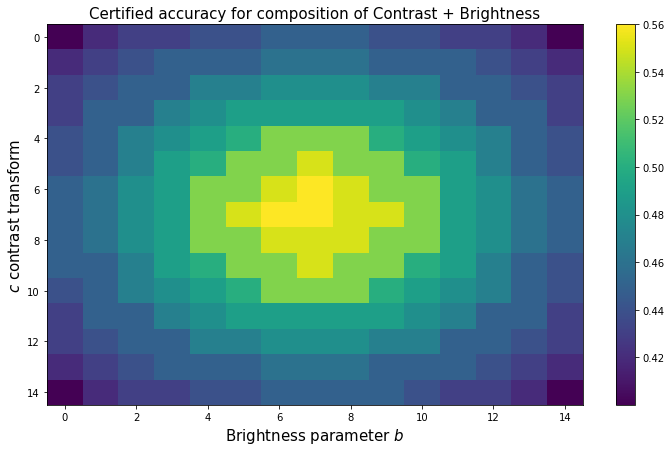

In [36]:
accdf, clps, acc_d = make_accuracy_df_cb(betas = betas, hs = pas, hatg_int = hatg_int, correct = isOk, safe_beta = safe_beta, ifTSS = False, ifOURnew=True)

In [37]:
min(list(acc_d.values()))

0.4

100%|█████████████████████████████████████████| 225/225 [01:23<00:00,  2.70it/s]


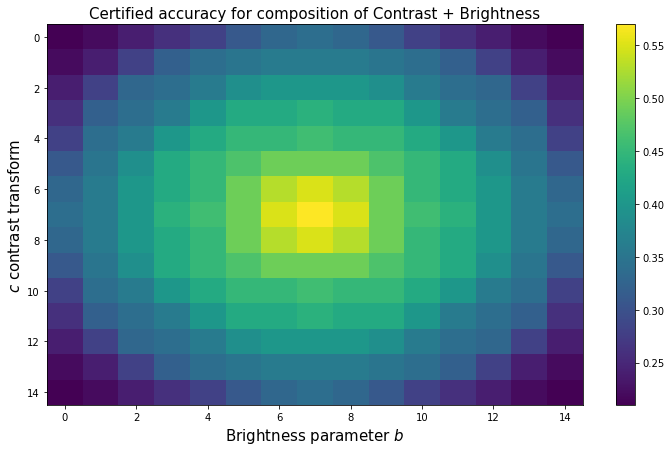

In [39]:
accdf_tss, clps_tss, acc_d_tss = make_accuracy_df_cb(betas = betas, hs = pas, hatg_int = hatg_int, correct = isOk, safe_beta = safe_beta_tss_tr, ifTSS = True, ifOURnew=False)

In [40]:
min(list(acc_d_tss.values()))

0.21

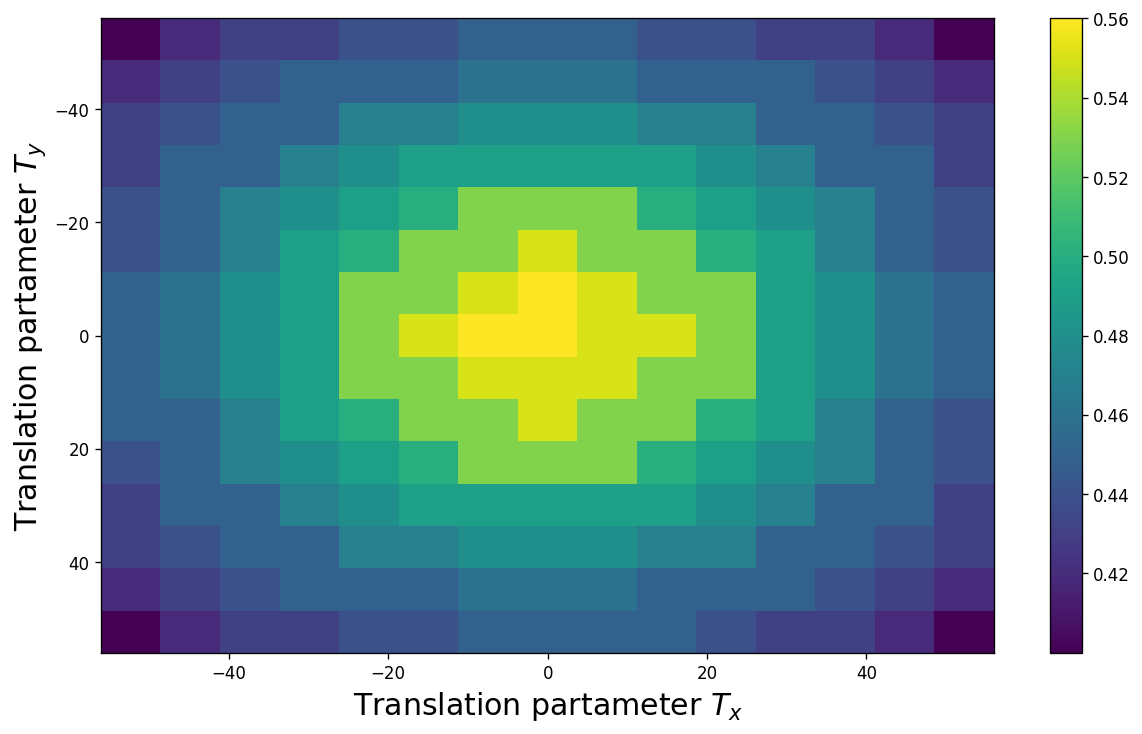

In [41]:
plt.figure(figsize=(12,7), dpi=120)
plt.imshow(clps, extent=[-56, 56, 56, -56], aspect='auto')
#plt.set_ylabel([1., 11.])
# plt.title('Certified accuracy for composition of Gamma+Contrast. Our', fontsize=15)
plt.xlabel(r'Translation partameter $T_x$', fontsize=18)
plt.ylabel(r'Translation partameter $T_y$', fontsize=18)
plt.colorbar();
plt.savefig(dirname+'Translation.pdf')
plt.show()

# TRANS BLUR BRIGHT CONTRAST

In [397]:
sigma_tr = 30
sigma_blur = 4
sigma_b = 0.8
sigma_c = 0.8

(array([  6.,  13.,  57., 116., 195., 250., 198.,  98.,  47.,  20.]),
 array([-3.2075    , -2.608904  , -2.010308  , -1.4117119 , -0.81311595,
        -0.21451998,  0.38407603,  0.98267204,  1.5812681 ,  2.179864  ,
         2.77846   ], dtype=float32),
 <BarContainer object of 10 artists>)

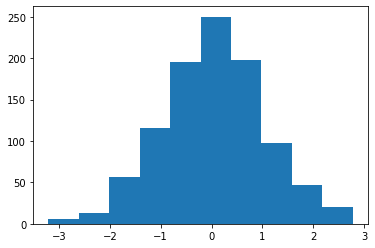

In [398]:
ns = torch.randn(1000).numpy()
plt.hist(ns)

In [399]:
# plt.hist(np.array(sigma_blur*norm_to_exp(ns, 1)))

(array([688., 228.,  52.,  17.,  11.,   1.,   0.,   1.,   1.,   1.]),
 array([ 0.07969369,  1.4960752 ,  2.9124565 ,  4.328838  ,  5.7452197 ,
         7.161601  ,  8.577983  ,  9.994364  , 11.410746  , 12.8271265 ,
        14.243508  ], dtype=float32),
 <BarContainer object of 10 artists>)

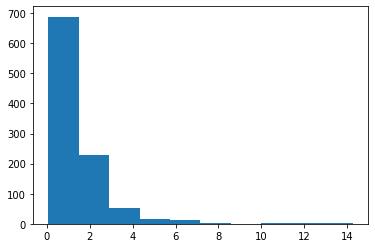

In [400]:
plt.hist(torch.exp(sigma_c*torch.randn(1000)).numpy())

In [401]:
ns = 10000
x0 = jnp.array([1.1,0.3]) # WHATEVER 
d = 5
b_zero = jnp.array([0.0, 0.0, 0.0,0.0, 1.0])

betas1 = jnp.linspace(-5, 5, 5) ## set a bit larger range than you want to certify
betas2 = jnp.linspace(-5, 5, 5)
betas3 = jnp.linspace(0, 3, 6)
betas4 = jnp.linspace(-0.2, 0.2, 5)
betas5 = jnp.linspace(0.9, 1.1, 5)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3, betas4, betas5)))) 



type_of_transform = 'tbbc_ray'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)


100%|███████████████████████████████████████| 3750/3750 [06:28<00:00,  9.65it/s]


In [ ]:
z = csaps([betas1, betas2, betas3, betas4, betas5], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape, *betas4.shape, *betas5.shape)) # interpolate


hg = []

for beta in tqdm(betas):
    hat_g = g_to_hat_g(z, beta, b_zero)
    hg.append(hat_g)
    
hat_g = jnp.asarray(hg)

hatg_int = csaps([betas1, betas2, betas3, betas4, betas5], hat_g.reshape(*betas1.shape, *betas2.shape, *betas3.shape, *betas4.shape, *betas5.shape)) #intterpolation of Integral g(beta)

  4%|█▍                                      | 137/3750 [00:14<06:20,  9.49it/s]

In [ ]:
import cv2 
import math

class Gaussian:
    # it adopts uniform distribution
    def __init__(self, sigma):
        self.sigma = sigma
        self.sigma2 = sigma ** 2.0

    def gen_param(self):
        r = random.uniform(0.0, self.sigma2)
        return r

    def proc(self, input, r2):
        if (abs(r2) < 1e-6):
            return input
        input = input.cpu().numpy()
        out = cv2.GaussianBlur(input.transpose(1, 2, 0), (0, 0), math.sqrt(r2), borderType=cv2.BORDER_REFLECT101)
        if out.ndim == 2:
            out = np.expand_dims(out, 2)
        out = torch.from_numpy(out.transpose(2, 0, 1))
        return out #.cuda()
    
    def proc_new(self, input, r2):
        if (abs(r2) < 1e-6):
            return input
#         print(input.shape)
        input = input.cpu().numpy()
#         print(input.shape)
        out = cv2.GaussianBlur(input.transpose(1, 2, 0), (0, 0), math.sqrt(r2), borderType=cv2.BORDER_REFLECT101)
        if out.ndim == 2:
            out = np.expand_dims(out, 2)
        out = torch.from_numpy(out.transpose(2, 0, 1))
        
        return out #.cuda()

    def batch_proc(self, inputs):
        outs = torch.zeros_like(inputs)
        for i in range(len(inputs)):
            outs[i] = self.proc(inputs[i], self.gen_param())
        return outs
    
class ExpGaussian(Gaussian):
    # it adopts exponential distribution
    # where the sigma is actually lambda in exponential distribution Exp(1/lambda)
    def __init__(self, sigma):
        super(ExpGaussian, self).__init__(sigma)
        self.sigma = sigma

    def gen_param(self):
#         r = - self.sigma * math.log(random.uniform(0.0, 1.0))
        r = np.random.exponential(scale=self.sigma)
        r = r#.to(device)
        return r
    
class RayGaussian(Gaussian):
    # it adopts exponential distribution
    # where the sigma is actually lambda in exponential distribution Exp(1/lambda)
    def __init__(self, sigma):
        super(RayGaussian, self).__init__(sigma)
        self.sigma = sigma

    def gen_param(self):
#         r = - self.sigma * math.log(random.uniform(0.0, 1.0))
        r = np.random.rayleigh(scale=self.sigma)
        return r

In [ ]:
def norm_to_exp_torch(s, lam):
    norm1 = torch.randn(s)
    norm2 = torch.randn(s)
    norm3 = torch.randn(s)
    norm4 = torch.randn(s)
    return torch.abs(norm1 * norm2 - norm3 * norm4) / lam
    

In [ ]:
import cv2

def attack_blur_cv2(x, b):
    r = b 
    input = x[0].cpu().numpy()
    r = r.item()
    out = cv2.GaussianBlur(input.transpose(1, 2, 0), (0, 0), np.sqrt(r), borderType=cv2.BORDER_REFLECT101)
    out = torch.from_numpy(out.transpose(2, 0, 1))
    return out[None, :].to(device)
    
    
def phi_blur_torch_batch_and_noise(x, sigma_blur = sigma_blur):
    
    if not exp_smoothing:
        norm1 = torch.randn(len(x))
        norm2 = torch.randn(len(x))
        ray = torch.sqrt(norm1**2 + norm2**2)
        exp = ray ** 2
        blur_radii = sigma_blur * exp
    else:
        blur_radii = norm_to_exp_torch(len(x), sigma_blur)

#     blur_radii = sigma_blur * norm_to_exp_torch(torch.randn(len(x)))
    for i in range(len(x)):
        x[i] = attack_blur_cv2(x[i][None, :], blur_radii[i])
    return x.to(device)

In [ ]:
def attack_tbbc_torch(x, b):  # tr bl br c

    x = x.to(device)
    translation = torch.tensor([[b[0].item(), b[1].item()]]).to(torch.float).to(device) 
    x = kornia.geometry.transform.translate(x, translation, padding_mode='reflection')
    x = attack_blur_cv2(x, b = b[2])
    x = x + torch.tensor(b[3].item())
    x = torch.tensor(b[4].item())*x
    return x

def phi_tbbc_torch_batch_and_noise(x): 
    x = x.to(device)
    
    c1 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    c2 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    t = torch.tensor([1,0])
    T = t.expand(len(x), *t.shape).clone()
    T[:, 0] = c1.squeeze().clone()
    T[:, 1] = c2.squeeze().clone()
    x = kornia.geometry.transform.translate(x.to(device), T.float().to(device), padding_mode='reflection')
    
    x = phi_blur_torch_batch_and_noise(x)
#     if exp_smoothing:
#         blur = ExpGaussian(sigma_blur)
#     else:
#         blur = RayGaussian(sigma_blur)
#     x = blur.batch_proc(x)
    
    b = (torch.randn(len(x)) * sigma_b)[:, None, None, None].to(device)
    x = x + b
    
    c = torch.exp(torch.randn(len(x)) * sigma_c)[:, None, None, None].to(device)
    x = c * x
    
    return x

In [ ]:
checkpoint = torch.load('../checkpoints/trans_blur_bright_contrast/TransBrightBlurContrast_40_04_10_04_checkpoint.pth.tar')
model = torchvision.models.resnet50(pretrained=False).to(device)#.cuda()
normalize_layer = get_normalize_layer('imagenet', device).to(device)#.cuda()
model = torch.nn.Sequential(normalize_layer, model)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [ ]:
exp_smoothing = False

In [ ]:
betas1 = jnp.linspace(-3, 3, 3) ## set a bit larger range than you want to certify
betas2 = jnp.linspace(-3, 3, 3)
betas3 = jnp.linspace(1, 3, 3)
betas4 = jnp.linspace(-0.1, 0.1, 3)
betas5 = jnp.linspace(0.95, 1.05, 3)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3, betas4, betas5)))) 

In [ ]:
attack = attack_tbbc_torch

era = ERA_Only_ND(model, dataloader100, attack =attack , device=device, PSN = betas)

In [ ]:
print(era)

In [ ]:
Accuracy(model, dataloader100, device)


In [ ]:
# betas1 = jnp.linspace(-12, 12, 5) ## set a bit larger range than you want to certify
# betas2 = jnp.linspace(-12, 12, 5)
# betas3 = jnp.linspace(0.01, 3, 5)
# betas4 = jnp.linspace(-0.3, 0.3, 5)
# betas5 = jnp.linspace(0.7, 1.3, 5)
# betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3, betas4, betas5)))) 

In [ ]:
Phi = phi_tbbc_torch_batch_and_noise
pas, isOk, paTSS, isOkTSS = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device, n0=100, maxn=2000, alpha=1e-3, batch_size=256, adaptive=False)

In [ ]:
isOk.mean()

In [ ]:
plt.hist(pas, bins=10)

In [ ]:
xi(0.99)

In [ ]:
betas1 = jnp.linspace(-3, 3, 5) ## set a bit larger range than you want to certify
betas2 = jnp.linspace(-3, 3, 5)
betas3 = jnp.linspace(0, 3, 3)
betas4 = jnp.linspace(-0.1, 0.1, 5)
betas5 = jnp.linspace(0.95, 1.05, 5)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3, betas4, betas5)))) 

In [ ]:
hlist = [0.5, 0.55, 0.555, 0.56, 0.57, 0.58, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65,0.68, 0.7, 0.72, 0.73,0.78,0.783, 0.79, 0.8, 0.91, 0.92, 0.93,0.95, 0.96,0.965, 0.97, 0.98, 0.99, 1]
hlist = np.linspace(0.5, 1, 300)
hmin = CertAccChecker(betas=betas, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((pas>hmin).astype('int')*isOk).mean()
print('Cert Acc TBBC our', cert_acc_within_betas_bounds, 'h_min is', hmin)

$\tilde{p}_A>1-\exp \left(-\lambda_B \alpha_B\right)\left(1-\Phi\left(\sqrt{\frac{\alpha_k^2}{\sigma_k^2}+\frac{\alpha_b^2}{e^{-2 \alpha_k} \sigma_b^2}+\frac{\alpha_{T x}^2+\alpha_{T y}^2}{\sigma_T^2}}\right)\right) .$

In [ ]:
# sigma_b = 0.3
# sigma_c = 0.3
# sigma_tr = 10
# sigma_blur = 3
# safe_beta_tss(xi, h, [*beta]).item():
def safe_beta_tss_tbbc(xi, h, bs):
    Tx = bs[0]
    Ty = bs[1]
    B = bs[2]
    b = bs[3]
    k = np.log(bs[4])
    q = k**2/sigma_c**2 + b**2/(np.exp(-2*k) * sigma_b**2) + (Tx**2+Ty**2)/(sigma_tr**2)
    q = scipy.stats.norm.cdf(q)
    q = 1-q
    sb = 1  # sigma_blur
    q1 = np.exp(-B/sigma_blur)
    
    return h>(1-q1*q)
    
    

In [ ]:
hlist = [0.5, 0.6, 0.63, 0.65, 0.66, 0.67, 0.68, 0.7, 0.73, 0.74, 0.75,0.8, 0.9, 0.92, 0.995, 0.99555,0.9965, 0.997, 0.999, 0.99999999999999]
hlist = np.linspace(0.5, 1, 300)
hmin = CertAccCheckerTSS(betas=betas, hlist=hlist, xi=xi_tss, safe_beta_tss=safe_beta_tss_tbbc)
cert_acc_within_betas_bounds = ((paTSS>hmin)*isOkTSS).mean()
print('Cert Acc CB TSS', cert_acc_within_betas_bounds, 'h_min is', hmin)

In [ ]:
def safe_beta(xi, h, hat_g, beta): # for certification
    print(hat_g(beta))
    print(-xi(1-h)+xi(0.5))
    return hat_g(beta) <= -xi(1-h)+xi(0.5)

In [ ]:
safe_beta(xi = xi, h=0.9, hat_g = hatg_int, beta = [*betas[0]])

In [ ]:
dirname

In [ ]:
d = {}

d['pas'] = list(pas)

d['isOk'] = list(map(int, list(isOk)))
d['paTSS'] = list(paTSS)
d['isOkTSS'] = list(map(int, list(isOkTSS)))

# pas, isOk, paTSS, isOkTSS

import json
with open('../results/TBBC_final.json', 'w') as f:
      json.dump(d, f, ensure_ascii=False)

In [ ]:
ns = 10000
x0 = jnp.array([1.1,0.3]) # WHATEVER 
d = 5
b_zero = jnp.array([0.0, 0.0, 0.0,0.0, 1.0])

betas1 = jnp.linspace(-5, 5, 5) ## set a bit larger range than you want to certify
betas2 = jnp.linspace(-5, 5, 5)
betas3 = jnp.linspace(0, 3, 6)
betas4 = jnp.linspace(-0.2, 0.2, 5)
betas5 = jnp.linspace(0.9, 1.1, 5)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3, betas4, betas5)))) 



type_of_transform = 'tbbc'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)

for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()



In [ ]:
for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()

In [ ]:
z = csaps([betas1, betas2, betas3, betas4, betas5], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape, *betas4.shape, *betas5.shape)) # interpolate


hg = []

for beta in tqdm(betas):
    hat_g = g_to_hat_g(z, beta, b_zero)
    hg.append(hat_g)
    
hat_g = jnp.asarray(hg)

hatg_int = csaps([betas1, betas2, betas3, betas4, betas5], hat_g.reshape(*betas1.shape, *betas2.shape, *betas3.shape, *betas4.shape, *betas5.shape)) #intterpolation of Integral g(beta)

In [ ]:
exp_smoothing = True
Phi = phi_tbbc_torch_batch_and_noise
pas, isOk, paTSS, isOkTSS = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device, n0=100, maxn=2000, alpha=1e-3, batch_size=256, adaptive=False)

In [ ]:
isOk.mean()

In [ ]:
plt.hist(pas, bins=10)

In [ ]:
xi(0.99)

In [ ]:
betas1 = jnp.linspace(-3, 3, 5) ## set a bit larger range than you want to certify
betas2 = jnp.linspace(-3, 3, 5)
betas3 = jnp.linspace(0, 3, 3)
betas4 = jnp.linspace(-0.1, 0.1, 5)
betas5 = jnp.linspace(0.95, 1.05, 5)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3, betas4, betas5)))) 

In [ ]:
hlist = [0.5, 0.55, 0.555, 0.56, 0.57, 0.58, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65,0.68, 0.7, 0.72, 0.73,0.78,0.783, 0.79, 0.8, 0.91, 0.92, 0.93,0.95, 0.96,0.965, 0.97, 0.98, 0.99, 1]
hlist = np.linspace(0.5, 1, 300)
hmin = CertAccChecker(betas=betas, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((pas>hmin).astype('int')*isOk).mean()
print('Cert Acc TBBC our', cert_acc_within_betas_bounds, 'h_min is', hmin)

$\tilde{p}_A>1-\exp \left(-\lambda_B \alpha_B\right)\left(1-\Phi\left(\sqrt{\frac{\alpha_k^2}{\sigma_k^2}+\frac{\alpha_b^2}{e^{-2 \alpha_k} \sigma_b^2}+\frac{\alpha_{T x}^2+\alpha_{T y}^2}{\sigma_T^2}}\right)\right) .$

In [ ]:
# sigma_b = 0.3
# sigma_c = 0.3
# sigma_tr = 10
# sigma_blur = 3
# safe_beta_tss(xi, h, [*beta]).item():
def safe_beta_tss_tbbc(xi, h, bs):
    Tx = bs[0]
    Ty = bs[1]
    B = bs[2]
    b = bs[3]
    k = np.log(bs[4])
    q = k**2/sigma_c**2 + b**2/(np.exp(-2*k) * sigma_b**2) + (Tx**2+Ty**2)/(sigma_tr**2)
    q = scipy.stats.norm.cdf(q)
    q = 1-q
    sb = 1  # sigma_blur
    q1 = np.exp(-B/sigma_blur)
    
    return h>(1-q1*q)
    
    

In [ ]:
hlist = [0.5, 0.6, 0.63, 0.65, 0.66, 0.67, 0.68, 0.7, 0.73, 0.74, 0.75,0.8, 0.9, 0.92, 0.995, 0.99555,0.9965, 0.997, 0.999, 0.99999999999999]
hlist = np.linspace(0.5, 0.6, 11)
hmin = CertAccCheckerTSS(betas=betas, hlist=hlist, xi=xi_tss, safe_beta_tss=safe_beta_tss_tbbc)
cert_acc_within_betas_bounds = ((paTSS>hmin)*isOkTSS).mean()
print('Cert Acc CB TSS', cert_acc_within_betas_bounds, 'h_min is', hmin)

In [ ]:
# sigma_b = 0.3
# sigma_c = 0.3
# sigma_tr = 10
# sigma_blur = 3
# safe_beta_tss(xi, h, [*beta]).item():
def safe_beta_tss_tbbc(xi, h, bs):
    Tx = bs[0]
    Ty = bs[1]
    B = bs[2]
    b = bs[3]
    k = np.log(bs[4])
    q = k**2/sigma_c**2 + b**2/(np.exp(-2*k) * sigma_b**2) + (Tx**2+Ty**2)/(sigma_tr**2)
    q = scipy.stats.norm.cdf(q)
    q = 1-q
    sb = 1  # sigma_blur
    q1 = np.exp(-B/sigma_blur)
    
    return h>(1-q1*q)


hlist = [0.5, 0.6, 0.63, 0.65, 0.66, 0.67, 0.68, 0.7, 0.73, 0.74, 0.75,0.8, 0.9, 0.92, 0.995, 0.99555,0.9965, 0.997, 0.999, 0.99999999999999]
# hlist = np.linspace(0.5, 1, 300)
hlist = np.linspace(0.5, 1, 300)
hmin = CertAccCheckerTSS(betas=betas, hlist=hlist, xi=xi_tss, safe_beta_tss=safe_beta_tss_tbbc)
cert_acc_within_betas_bounds = ((paTSS>hmin)*isOkTSS).mean()
print('Cert Acc CB TSS', cert_acc_within_betas_bounds, 'h_min is', hmin)
    
    
    


## some experiments to deal with rayleigh

In [74]:
# def norm_to_exp(a):
    
#     return jnp.log(2/jax.lax.erfc(a/jnp.sqrt(2)))

In [75]:
sigma_b = 0.2
sigma_c = 0.2
sigma_tr = 10
sigma_blur = 3

(array([ 10.,  28.,  66., 164., 228., 222., 164.,  92.,  23.,   3.]),
 array([-3.1130779 , -2.4977143 , -1.8823507 , -1.266987  , -0.65162337,
        -0.03625977,  0.5791038 ,  1.1944674 ,  1.8098311 ,  2.4251947 ,
         3.0405583 ], dtype=float32),
 <BarContainer object of 10 artists>)

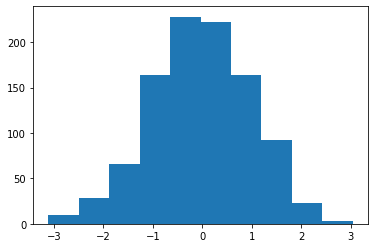

In [76]:
ns = torch.randn(1000).numpy()
plt.hist(ns)


In [352]:
plt.hist(np.random.exponential(loc=1/sigma_blur))

TypeError: exponential() got an unexpected keyword argument 'loc'

(array([ 16.,  89., 259., 273., 198.,  93.,  50.,  13.,   7.,   2.]),
 array([0.5106694 , 0.6488567 , 0.78704405, 0.92523134, 1.0634186 ,
        1.2016059 , 1.3397932 , 1.4779806 , 1.6161679 , 1.7543552 ,
        1.8925425 ], dtype=float32),
 <BarContainer object of 10 artists>)

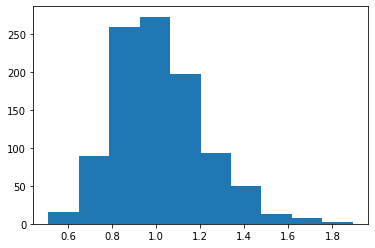

In [80]:
plt.hist(torch.exp(sigma_c*torch.randn(1000)).numpy())

In [86]:
hs.max()

0.999010141478227

In [87]:
betas1 = jnp.linspace(-10, 10, 5) ## set a bit larger range than you want to certify
betas2 = jnp.linspace(-10, 10, 5)
betas3 = jnp.linspace(0.0, 3, 3)
betas4 = jnp.linspace(-0.2, 0.2, 5)
betas5 = jnp.linspace(0.7, 1.3, 5)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3, betas4, betas5)))) 

In [92]:
sigma = 0.2
lamb = 1/sigma
ray_true = np.random.rayleigh(scale = (1/np.sqrt(2*lamb)), size=10000)
exp_true = np.random.exponential(scale = sigma, size=10000)

if $X \sim \operatorname{Exponential}(\lambda)$, then $Y=\sqrt{X} \sim$ Rayleigh $(1 / \sqrt{2 \lambda})$

In [ ]:
1/0.2**2/2

In [ ]:
plt.hist(ray_true, bins=50)
plt.show()

In [ ]:
plt.hist(3*np.sqrt(exp_true), bins=50)
plt.show()

In [ ]:
plt.hist(3*ray_true**2, bins=50)
plt.show()

In [ ]:
plt.hist(3*ray_true**2, bins=50)
plt.show()

In [ ]:
1/0.8

In [ ]:
plt.hist(np.random.exponential(scale=1/1, size=1000), bins=50)
plt.show()

In [ ]:
plt.hist(exp_true, bins=50)
plt.show()